In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
import re
import os
import pandas as pd
import numpy as np
import sklearn
import math
import scipy
import matplotlib.pyplot as plt
import pickle
import operator
import skmisc
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import Pipeline
from scipy.stats import skew
from math import sqrt
from IPython.display import display
from scipy.cluster import hierarchy as hc
from pdpbox import pdp
from plotnine import *
import xgboost as xgb
from eli5 import show_weights, explain_weights_xgboost

In [3]:
DATA_DIR = "data/"
DATA_RAW = DATA_DIR+"raw/"
DATA_TEMP = DATA_DIR+"temp/"
MODELS_DIR = "models/"
os.listdir(DATA_RAW)

['.DS_Store',
 '2008.csv',
 'test.csv',
 'data_description.txt',
 'train.csv',
 'sample_submission.csv']

# Load Data

In [4]:
%time df_train_raw = pd.read_csv(f"{DATA_RAW}train.csv")
%time df_test_raw = pd.read_csv(f"{DATA_RAW}test.csv")

CPU times: user 30.6 ms, sys: 9.09 ms, total: 39.7 ms
Wall time: 55.5 ms
CPU times: user 24.9 ms, sys: 3.52 ms, total: 28.4 ms
Wall time: 29.5 ms


In [5]:
print(df_train_raw.shape)
df_test_raw.shape

(1460, 81)


(1459, 80)

In [6]:
sale_price = df_train_raw["SalePrice"]
df_train = df_train_raw.drop(["SalePrice"], axis=1)
df_train.shape
train_size = df_train.shape[0]

In [514]:
df = pd.concat([df_train, df_test_raw])

In [515]:
df = df.reset_index(drop=True)

In [516]:
def missing_values_stats(df, keep_zeros=False):
    """
        The function return stats on the missing values in the dataframe.
        
        Inputs:
            df: dataframe to analyze
            keep_zeros: boolean to specify if the columns with zeros missing values are kept in the stats.
        
        Outputs:
            res: A data frame containing for each columns of df the total of missing values and the percetage.
        
    """
    res = pd.DataFrame()
    res["Total"] = df.isnull().sum().sort_values(ascending=False)
    res["Percentage"] = np.round((res["Total"]/len(df))*100, 2)
    if not keep_zeros:
        res = res.loc[res.Total > 0, ["Total", "Percentage"]]
    return res

In [517]:
categorical_features = [col_name for col_name, col in df_train_raw.items() if pd.api.types.is_object_dtype(col)]
numerical_features = [col_name for col_name, col in df_train_raw.items() if not pd.api.types.is_object_dtype(col)]

In [518]:
pd.DataFrame([len(df_train_raw[feat].unique()) for feat in numerical_features], index=numerical_features, columns=["Cardinality"]).sort_values("Cardinality")

,Cardinality
BsmtHalfBath,3
HalfBath,3
FullBath,4
BsmtFullBath,4
Fireplaces,4
KitchenAbvGr,4
GarageCars,5
YrSold,5
BedroomAbvGr,8
PoolArea,8


In [519]:
cat_feats = categorical_features + ["BsmtHalfBath", "HalfBath", "FullBath", "BsmtFullBath", 
                        "KitchenAbvGr", "GarageCars", "BedroomAbvGr", "OverallCond", "OverallQual",
                       "TotRmsAbvGrd", "MSSubClass"]

In [520]:
df_cat = df[cat_feats]
df_num = df[[col_name for col_name in df.columns if (not col_name in df_cat.columns) and col_name != "Id"]]

In [521]:
df_num.columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'Fireplaces', 'GarageYrBlt',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

# Numerical Features

In [522]:
miss_num = missing_values_stats(df_num)
miss_num

,Total,Percentage
LotFrontage,486,16.65
GarageYrBlt,159,5.45
MasVnrArea,23,0.79
BsmtFinSF1,1,0.03
BsmtFinSF2,1,0.03
BsmtUnfSF,1,0.03
GarageArea,1,0.03
TotalBsmtSF,1,0.03


In [523]:
# Check if the last missing features are from the same entry
df_num.loc[df_num.TotalBsmtSF.isnull(), ["TotalBsmtSF", "GarageArea", "BsmtUnfSF", "BsmtFinSF2", "BsmtFinSF1"]]

,TotalBsmtSF,GarageArea,BsmtUnfSF,BsmtFinSF2,BsmtFinSF1
2120,NaN,280.0,NaN,NaN,NaN


In [524]:
# Nice the missing Bsmt* features are from the same entry, let have a look at the BsmtCond feature to check if the house have a basement
df_cat.loc[df_num[df_num.TotalBsmtSF.isnull()].index, "BsmtCond"]

2120    NaN
Name: BsmtCond, dtype: object

In [525]:
# From the data description NaN mean that the house does not have a basement, hence the missing Bsmt* features are set to 0
df_num["TotalBsmtSF"] = df_num["TotalBsmtSF"].fillna(0)
df_num["BsmtUnfSF"] = df_num["BsmtUnfSF"].fillna(0)
df_num["BsmtFinSF2"] = df_num["BsmtFinSF2"].fillna(0)
df_num["BsmtFinSF1"] = df_num["BsmtFinSF1"].fillna(0)
df_num.loc[2120, ["TotalBsmtSF", "BsmtUnfSF", "BsmtFinSF2", "BsmtFinSF1"]]

TotalBsmtSF    0.0
BsmtUnfSF      0.0
BsmtFinSF2     0.0
BsmtFinSF1     0.0
Name: 2120, dtype: float64

In [526]:
# Now let have a look at garage area, and check if the corresponding house hase a garage
df_cat.loc[df_num[df_num.GarageArea.isnull()].index, "GarageType"]

2576    Detchd
Name: GarageType, dtype: object

In [527]:
df_cat.loc[df_num[df_num.GarageArea.isnull()].index, "Neighborhood"]

2576    IDOTRR
Name: Neighborhood, dtype: object

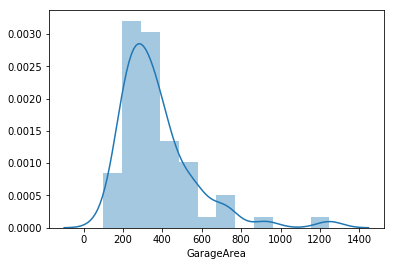

In [528]:
sns.distplot(df_num.loc[df_cat.loc[(df_cat.GarageType == "Detchd") & (df_cat.Neighborhood == "IDOTRR")].index, "GarageArea"].dropna())

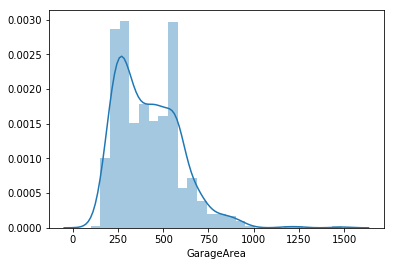

In [529]:
sns.distplot(df_num.loc[df_cat.loc[(df_cat.GarageType == "Detchd")].index, "GarageArea"].dropna())

In [530]:
print("median Detchd and IDOTRR", df_num.loc[df_cat.loc[(df_cat.GarageType == "Detchd") & (df_cat.Neighborhood == "IDOTRR")].index, "GarageArea"].dropna().median())
print("median Detchd", df_num.loc[df_cat.loc[(df_cat.GarageType == "Detchd")].index, "GarageArea"].dropna().median())
print("median IDOTRR", df_num.loc[df_cat.loc[(df_cat.Neighborhood == "IDOTRR")].index, "GarageArea"].dropna().median())

median Detchd and IDOTRR 314.0
median Detchd 399.5
median IDOTRR 288.0


In [531]:
# We replace the Nan value by the median of the GarageArea distribution of Detchd garage in the IDOTRR neighborhood
df_num.loc[df_num.GarageArea.isnull(), "GarageArea"] = df_num.loc[df_cat.loc[(df_cat.GarageType == "Detchd") & (df_cat.Neighborhood == "IDOTRR")].index, "GarageArea"].dropna().median()

In [532]:
miss_num = missing_values_stats(df_num)
miss_num

,Total,Percentage
LotFrontage,486,16.65
GarageYrBlt,159,5.45
MasVnrArea,23,0.79


In [533]:
yearblt = df_num.loc[df_num.GarageYrBlt.isnull(), ["YearBuilt"]]

In [534]:
df_num.loc[df_num.GarageYrBlt.isnull(), ["GarageYrBlt"]]

,GarageYrBlt
39,NaN
48,NaN
78,NaN
88,NaN
89,NaN
99,NaN
108,NaN
125,NaN
127,NaN
140,NaN


In [535]:
# It seems that the more commun is to set GarageYrBlt equal to YearBuilt if the house has no garage 
df_num["GarageYrBlt"].fillna(df_num["YearBuilt"], inplace=True)

In [536]:
df_cat.loc[df_num.loc[df_num.GarageYrBlt.isnull()].index, "GarageType"].value_counts()

Series([], Name: GarageType, dtype: int64)

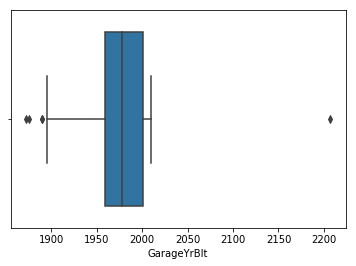

In [537]:
sns.boxplot(df_num["GarageYrBlt"])

In [538]:
# 1 outliner, let have a look if it suppose have a garage
df_cat.loc[df_num.loc[df_num.GarageYrBlt > 2100].index, "GarageType"]

2592    Attchd
Name: GarageType, dtype: object

In [539]:
# The garage is attached to the house, so we can safely assume that the garage has been built at the time or 
df_num.loc[df_num.loc[df_num.GarageYrBlt > 2100].index, ["YearBuilt", "YearRemodAdd"]]

,YearBuilt,YearRemodAdd
2592,2006,2007


In [540]:
# the house has been remodeled a year later, so we are going to asssume that the garage has been built as the time
df_num.loc[df_num.loc[df_num.GarageYrBlt > 2100].index, "GarageYrBlt"] = 2006

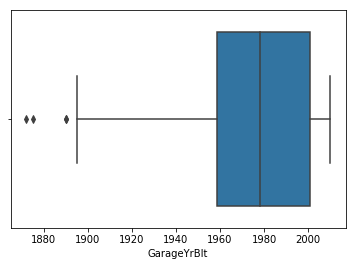

In [541]:
# No more weird outliers
sns.boxplot(df_num["GarageYrBlt"])

In [542]:
miss_num = missing_values_stats(df_num)
miss_num

,Total,Percentage
LotFrontage,486,16.65
MasVnrArea,23,0.79


In [543]:
# The best way to fill the missing values is to replace the them by the median of the neighborhood
temp = pd.DataFrame(df_num["LotFrontage"])
temp = temp.join(df_cat["Neighborhood"])
temp = temp.groupby("Neighborhood").median()
#temp = temp.reset_index()

In [544]:
for idx in df_num.loc[df_num.LotFrontage.isnull()].index:
    df_num.loc[idx, "LotFrontage"] = temp.loc[df_cat.loc[idx, "Neighborhood"], "LotFrontage"]

In [545]:
# MasVnrArea
print("# miss MasVnrArea: ", len(df_num.loc[df_num.MasVnrArea.isnull()].index))
print("# miss MasVnrType: ", len(df_cat.loc[df_cat.MasVnrType.isnull()].index))
print(df_num.loc[df_num.MasVnrArea.isnull()].index)
print(df_cat.loc[df_cat.MasVnrType.isnull()].index)

# miss MasVnrArea:  23
# miss MasVnrType:  24
Int64Index([ 234,  529,  650,  936,  973,  977, 1243, 1278, 1691, 1706, 1882,
            1992, 2004, 2041, 2311, 2325, 2340, 2349, 2368, 2592, 2657, 2686,
            2862],
           dtype='int64')
Int64Index([ 234,  529,  650,  936,  973,  977, 1243, 1278, 1691, 1706, 1882,
            1992, 2004, 2041, 2311, 2325, 2340, 2349, 2368, 2592, 2610, 2657,
            2686, 2862],
           dtype='int64')


In [546]:
# Most of the houses without MasVnr have an MasVnrArea of 0
df_num.loc[df_cat.MasVnrType == "None", "MasVnrArea"].value_counts()

0.0      1735
1.0         3
285.0       1
312.0       1
344.0       1
288.0       1
Name: MasVnrArea, dtype: int64

In [547]:
df_num.loc[df_num.MasVnrArea.isnull(), "MasVnrArea"] = 0

In [548]:
missing_values_stats(df_num)

,Total,Percentage


# Categorical features

In [549]:
missing_values_stats(df_cat)

,Total,Percentage
PoolQC,2909,99.66
MiscFeature,2814,96.40
Alley,2721,93.22
Fence,2348,80.44
FireplaceQu,1420,48.65
GarageFinish,159,5.45
GarageQual,159,5.45
GarageCond,159,5.45
GarageType,157,5.38
BsmtCond,82,2.81


In [550]:
df_cat["PoolQC"].fillna("No_Pool", inplace=True)
df_cat["MiscFeature"].fillna("No_Feature", inplace=True)
df_cat["Alley"].fillna("No_Alley", inplace=True)
df_cat["Fence"].fillna("No_Fence", inplace=True)
df_cat["FireplaceQu"].fillna("No_Fireplace", inplace=True)
df_cat["GarageCond"].fillna("No_Garage", inplace=True)
df_cat["GarageType"].fillna("No_Garage", inplace=True)
df_cat["GarageQual"].fillna("No_Garage", inplace=True)
df_cat["GarageFinish"].fillna("No_Garage", inplace=True)
df_cat["BsmtFinType2"].fillna("No_Basement", inplace=True)
df_cat["BsmtExposure"].fillna("No_Basement", inplace=True)
df_cat["BsmtFinType1"].fillna("No_Basement", inplace=True)
df_cat["BsmtCond"].fillna("No_Basement", inplace=True)
df_cat["BsmtQual"].fillna("No_Basement", inplace=True)

In [551]:
miss_cat = missing_values_stats(df_cat)

In [552]:
miss_cat

,Total,Percentage
MasVnrType,24,0.82
MSZoning,4,0.14
Functional,2,0.07
BsmtHalfBath,2,0.07
BsmtFullBath,2,0.07
Utilities,2,0.07
GarageCars,1,0.03
Electrical,1,0.03
KitchenQual,1,0.03
SaleType,1,0.03


In [553]:
# Garage cars is probably hugely correlated with GarageArea.
# So let look at the GarageArea feature, then we look at the GarageCars of the others houses with the same GarageArea
df_num.loc[df_cat[df_cat.GarageCars.isnull()].index, "GarageArea"]

2576    314.0
Name: GarageArea, dtype: float64

In [554]:
df_cat.loc[df_cat.GarageCars.isnull(), "GarageType"]

2576    Detchd
Name: GarageType, dtype: object

In [555]:
df_cat.loc[2576, ["GarageType", "GarageFinish", "GarageQual", "GarageCond", "GarageCars"]]

GarageType         Detchd
GarageFinish    No_Garage
GarageQual      No_Garage
GarageCond      No_Garage
GarageCars            NaN
Name: 2576, dtype: object

In [556]:
# It seems that for the house 2576, most variable indicate an absence of garage
df_cat.loc[2576, "GarageType"] = "No_Garage"
df_cat.loc[2576, "GarageCars"] = 0
df_num.loc[2576, "GarageArea"] = 0

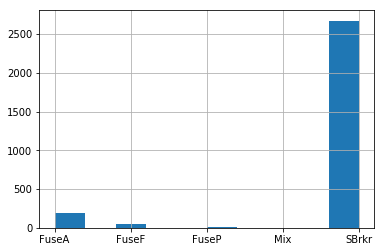

In [557]:
## Electrical
df_cat["Electrical"].hist()
df_cat["Electrical"] = df_cat["Electrical"].fillna("SBrkr") # Most common value

In [558]:
## KitchenQual

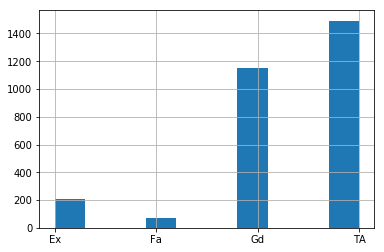

In [559]:
df_cat["KitchenQual"].hist()
df_cat["KitchenQual"] = df_cat["KitchenQual"].fillna("TA")

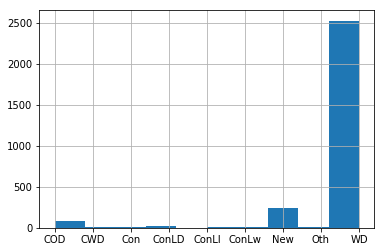

In [560]:
df_cat["SaleType"].hist()
df_cat["SaleType"] = df_cat["SaleType"].fillna("WD")

In [561]:
# the two missing values for exterior are he same house, we fill with most common value
df_cat["Exterior1st"] = df_cat["Exterior1st"].fillna("VinylSd")
df_cat["Exterior2nd"] = df_cat["Exterior2nd"].fillna("VinylSd")

In [562]:
# We look at the most common utility by neighborhood
print(df_cat.loc[df_cat.Utilities.isnull(), "Neighborhood"])
print(df_cat.loc[df_cat.Neighborhood == "IDOTRR", "Utilities"].value_counts())
print(df_cat.loc[df_cat.Neighborhood == "Gilbert", "Utilities"].value_counts())

1915     IDOTRR
1945    Gilbert
Name: Neighborhood, dtype: object
AllPub    92
Name: Utilities, dtype: int64
AllPub    164
Name: Utilities, dtype: int64


In [563]:
# In both neighborhood, all houses have AllPub as utilities
df_cat["Utilities"] = df_cat["Utilities"].fillna("AllPub")

In [564]:
## The houses with the missing BsmtFullBath, BsmtHalfBath does not have a basement
df_cat.loc[df_cat.BsmtFullBath.isnull(), ["BsmtQual", "BsmtFullBath", "BsmtHalfBath"]]

,BsmtQual,BsmtFullBath,BsmtHalfBath
2120,No_Basement,NaN,NaN
2188,No_Basement,NaN,NaN


In [565]:
df_cat["BsmtFullBath"] = df_cat["BsmtFullBath"].fillna(0.0)
df_cat["BsmtHalfBath"] = df_cat["BsmtHalfBath"].fillna(0.0)

In [566]:
# Functional
# From data description assumed typical 
df_cat["Functional"] = df_cat["Functional"].fillna("Typ")

In [567]:
# MasVnrArea
df_num.loc[df_cat[df_cat.MasVnrType.isnull()].index, "MasVnrArea"]

234       0.0
529       0.0
650       0.0
936       0.0
973       0.0
977       0.0
1243      0.0
1278      0.0
1691      0.0
1706      0.0
1882      0.0
1992      0.0
2004      0.0
2041      0.0
2311      0.0
2325      0.0
2340      0.0
2349      0.0
2368      0.0
2592      0.0
2610    198.0
2657      0.0
2686      0.0
2862      0.0
Name: MasVnrArea, dtype: float64

In [568]:
# if the MasVnrArea is 0 then there is MasVnrType has to be None
df_cat.loc[(df_num.loc[df_cat[df_cat.MasVnrType.isnull()].index, "MasVnrArea"] == 0).index, "MasVnrType"] = "None"

In [569]:
df_cat.loc[(df_cat.Neighborhood == "Mitchel") & (df_cat.MasVnrType != "None"), "MasVnrType"].unique()

array(['BrkFace', 'Stone'], dtype=object)

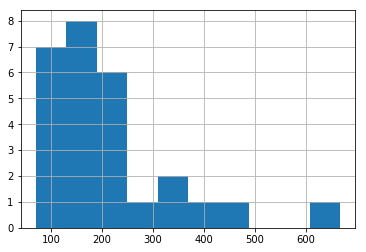

In [570]:
df_num.loc[df_cat.loc[(df_cat.Neighborhood == "Mitchel") & (df_cat.MasVnrType == "BrkFace")].index, "MasVnrArea"].hist()

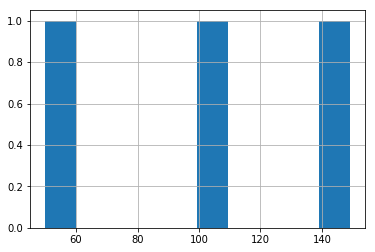

In [571]:
df_num.loc[df_cat.loc[(df_cat.Neighborhood == "Mitchel") & (df_cat.MasVnrType == "Stone")].index, "MasVnrArea"].hist()

In [572]:
# Most common MasVnrType by area by neighborhood
df_cat.loc[2610, "MasVnrType"] = "BrkFace"

In [573]:
missing_values_stats(df_cat)

,Total,Percentage
MSZoning,4,0.14


In [574]:
# MSZoning Identifies the general zoning classification of the sale
# We are using  the most common MSZoning by neighborhood
df_cat[df_cat.MSZoning.isnull()]

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,HalfBath,FullBath,BsmtFullBath,KitchenAbvGr,GarageCars,BedroomAbvGr,OverallCond,OverallQual,TotRmsAbvGrd,MSSubClass
1915,NaN,Grvl,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,...,0,1,0.0,1,1.0,1,4,2,4,30
2216,NaN,Pave,No_Alley,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,...,0,1,0.0,1,2.0,2,5,1,4,20
2250,NaN,Pave,No_Alley,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,...,0,2,0.0,1,1.0,4,1,5,7,70
2904,NaN,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,...,1,1,0.0,1,1.0,3,3,1,6,20


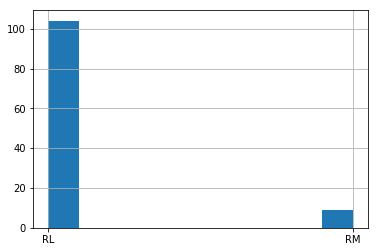

In [575]:
df_cat.loc[df_cat.Neighborhood == "Mitchel", "MSZoning"].hist()

In [576]:
df_cat.loc[(df_cat.MSZoning.isnull()) & (df_cat.Neighborhood == "Mitchel"), "MSZoning"] = "RL"

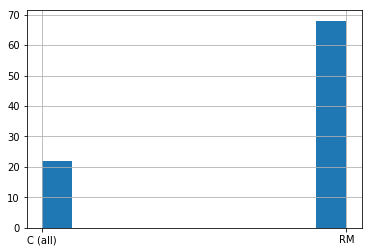

In [577]:
df_cat.loc[df_cat.Neighborhood == "IDOTRR", "MSZoning"].hist()

In [578]:
df_cat.loc[(df_cat.MSZoning.isnull()) & (df_cat.Neighborhood == "IDOTRR"), "MSZoning"] = "RM"

In [579]:
missing_values_stats(df_cat)

,Total,Percentage


In [580]:
for col_name in df_cat.columns:
    df_cat[col_name] = df_cat[col_name].astype("category")

In [581]:
df_cat.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'BsmtHalfBath', 'HalfBath', 'FullBath',
       'BsmtFullBath', 'KitchenAbvGr', 'GarageCars', 'BedroomAbvGr',
       'OverallCond', 'OverallQual', 'TotRmsAbvGrd', 'MSSubClass'],
      dtype='object')

In [582]:
df_cat["ExterQual"].cat.categories

Index(['Ex', 'Fa', 'Gd', 'TA'], dtype='object')

In [583]:
df_cat.ExterQual = df_cat.ExterQual.cat.reorder_categories(["Fa", "TA", "Gd", "Ex"], ordered=True)

In [584]:
df_cat["ExterCond"].cat.categories

Index(['Ex', 'Fa', 'Gd', 'Po', 'TA'], dtype='object')

In [585]:
df_cat.ExterCond = df_cat.ExterCond.cat.reorder_categories(["Po", "Fa", "TA", "Gd", "Ex"], ordered=True)

In [586]:
df_cat.BsmtCond.cat.categories

Index(['Fa', 'Gd', 'No_Basement', 'Po', 'TA'], dtype='object')

In [587]:
df_cat.BsmtCond = df_cat.BsmtCond.cat.reorder_categories(["No_Basement", "Po", "Fa", "TA", "Gd"], ordered=True)

In [588]:
df_cat.BsmtQual.cat.categories

Index(['Ex', 'Fa', 'Gd', 'No_Basement', 'TA'], dtype='object')

In [589]:
df_cat.BsmtQual = df_cat.BsmtQual.cat.reorder_categories(["No_Basement", "Fa", "TA", "Gd", "Ex"], ordered=True)

In [590]:
df_cat.BsmtExposure.cat.categories

Index(['Av', 'Gd', 'Mn', 'No', 'No_Basement'], dtype='object')

In [591]:
df_cat.BsmtExposure = df_cat.BsmtExposure.cat.reorder_categories(["No_Basement", "No", "Mn", "Av", "Gd"], ordered=True)

In [592]:
df_cat.HeatingQC.cat.categories

Index(['Ex', 'Fa', 'Gd', 'Po', 'TA'], dtype='object')

In [593]:
df_cat.HeatingQC = df_cat.HeatingQC.cat.reorder_categories(["Po", "Fa", "TA", "Gd", "Ex"], ordered=True)

In [594]:
df_cat.KitchenQual.cat.categories

Index(['Ex', 'Fa', 'Gd', 'TA'], dtype='object')

In [595]:
df_cat.KitchenQual = df_cat.KitchenQual.cat.reorder_categories(["Fa", "TA", "Gd", "Ex"], ordered=True)

In [596]:
df_cat.FireplaceQu.cat.categories

Index(['Ex', 'Fa', 'Gd', 'No_Fireplace', 'Po', 'TA'], dtype='object')

In [597]:
df_cat.FireplaceQu = df_cat.FireplaceQu.cat.reorder_categories(["No_Fireplace", "Po", "Fa", "TA", "Gd", "Ex"], ordered=True)

In [598]:
df_cat.GarageQual.cat.categories

Index(['Ex', 'Fa', 'Gd', 'No_Garage', 'Po', 'TA'], dtype='object')

In [599]:
df_cat.GarageQual = df_cat.GarageQual.cat.reorder_categories(["No_Garage", "Po", "Fa", "TA", "Gd", "Ex"], ordered=True)

In [600]:
df_cat.GarageCond.cat.categories

Index(['Ex', 'Fa', 'Gd', 'No_Garage', 'Po', 'TA'], dtype='object')

In [601]:
df_cat.GarageCond = df_cat.GarageCond.cat.reorder_categories(["No_Garage", "Po", "Fa", "TA", "Gd", "Ex"], ordered=True)

In [602]:
df_cat.PoolQC.cat.categories

Index(['Ex', 'Fa', 'Gd', 'No_Pool'], dtype='object')

In [603]:
df_cat.PoolQC = df_cat.PoolQC.cat.reorder_categories(["No_Pool", "Fa", "Gd", "Ex"], ordered=True)

In [604]:
df_cat.Fence.cat.categories

Index(['GdPrv', 'GdWo', 'MnPrv', 'MnWw', 'No_Fence'], dtype='object')

In [605]:
df_cat.Fence = df_cat.Fence.cat.reorder_categories(["No_Fence", "MnWw", "GdWo", "MnPrv", "GdPrv"], ordered=True)

In [606]:
df_cat.OverallCond.cat.as_ordered(True)
df_cat.OverallQual.cat.as_ordered(True)

In [754]:
df_cat.BsmtFinType1.cat.categories

Index(['ALQ', 'BLQ', 'GLQ', 'LwQ', 'No_Basement', 'Rec', 'Unf'], dtype='object')

In [755]:
df_cat.BsmtFinType1 = df_cat.BsmtFinType1.cat.reorder_categories(["No_Basement", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], ordered=True)

In [756]:
df_cat.BsmtFinType2.cat.categories

Index(['ALQ', 'BLQ', 'GLQ', 'LwQ', 'No_Basement', 'Rec', 'Unf'], dtype='object')

In [757]:
df_cat.BsmtFinType2 = df_cat.BsmtFinType2.cat.reorder_categories(["No_Basement", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], ordered=True)

In [758]:
df2 = pd.DataFrame(df["Id"]).join(df_cat).join(df_num)

In [759]:
missing_values_stats(df2)

,Total,Percentage


In [760]:
df2.to_feather(f"{DATA_TEMP}df2.frt")

# First Model

In [7]:
df2 = pd.read_feather(f"{DATA_TEMP}df2.frt")

In [8]:
y = np.log1p(sale_price)

In [9]:
df_train = df2[df2.index < len(sale_price)]

In [10]:
df_test = df2[df2.index >= len(sale_price)]

In [11]:
df_train.drop("Id", axis=1, inplace=True)

In [12]:
category_mapper = {col_name: {code: idx for code, idx in enumerate(col.cat.categories)} for col_name, col in df_train.items() if pd.api.types.is_categorical_dtype(col)}
category_inv_mapper = {col_name: {idx: code for code, idx in enumerate(col.cat.categories)} for col_name, col in df_train.items() if pd.api.types.is_categorical_dtype(col)}

In [13]:
for col_name, col in df_train.items():
    if pd.api.types.is_categorical_dtype(col):
        df_train[col_name] = col.cat.codes

In [14]:
print(df_test.MSZoning.cat.categories)
category_mapper["BsmtQual"]

Index(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype='object')


{0: 'No_Basement', 1: 'Fa', 2: 'TA', 3: 'Gd', 4: 'Ex'}

In [15]:
for col_name, col in df_test.items():
    if pd.api.types.is_categorical_dtype(col):
        df_test[col_name] = [category_inv_mapper[col_name][e] for e in col]

In [18]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [19]:
n_folds = 5
XGB = xgb.XGBRegressor()
params = {}
model = GridSearchCV(XGB, params, cv=n_folds, refit=True, scoring=make_scorer(rmse))
pipeline = Pipeline([("model", model)])
pipeline.fit(df_train, y)

Pipeline(memory=None,
     steps=[('model', GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs...ch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(rmse), verbose=0))])

In [20]:
def get_cv_score(pipeline):
    return [pipeline.named_steps["model"].cv_results_['mean_test_score'], pipeline.named_steps["model"].cv_results_['std_test_score'], ]

In [21]:
scores = get_cv_score(pipeline)
print("RMSE: %0.5f (+/- %0.5f)" % (scores[0], scores[1]))
score_baseline = scores[0]

RMSE: 0.12747 (+/- 0.00910)


In [25]:
pred = pipeline.predict(df_test.drop("Id", axis=1))

In [26]:
pd.DataFrame({"Id":df_test["Id"] , "SalePrice":np.exp(pred)-1}).to_csv("data/sub_xbg1.csv", index=False)

In [23]:
scores_sum = pd.DataFrame({"CV": scores[0], "LB":0.13700}, index=["baseline"])

In [24]:
scores_sum

,CV,LB
baseline,0.127475,0.137


# Features importance

In [22]:
def get_features_importance(pipeline, df):
    feat_imp_dict = pipeline.named_steps["model"].best_estimator_.get_booster().get_score(importance_type='weight')
    for feat in df.columns:
        if feat not in feat_imp_dict:
            feat_imp_dict[feat] = 0
    feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient="index").sort_values(0, ascending=False)
    feat_imp = feat_imp.reset_index()
    feat_imp.columns = ["Feature", "Importance"]
    return feat_imp
def print_features(feat_imp):
    plt.subplots(figsize=(10,10))
    sns.barplot(feat_imp["Importance"], feat_imp["Feature"])

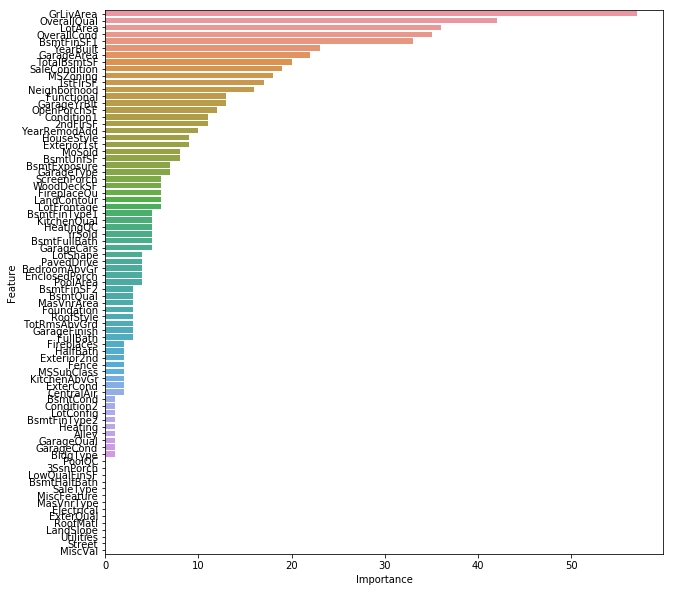

In [23]:
features_importance = get_features_importance(pipeline, df_train)
print_features(features_importance[:])

In [33]:
explain_weights_xgboost(pipeline.named_steps["model"].best_estimator_.get_booster(), top=90, importance_type='weight')

Weight,Feature
0.0974,GrLivArea
0.0718,OverallQual
0.0615,LotArea
0.0598,OverallCond
0.0564,BsmtFinSF1
0.0393,YearBuilt
0.0376,GarageArea
0.0342,TotalBsmtSF
0.0325,SaleCondition
0.0308,MSZoning


# Correlation

In [82]:
df_extra = df_train.join(np.log1p(df_train_raw["SalePrice"]))
corrmat = df_extra.corr()

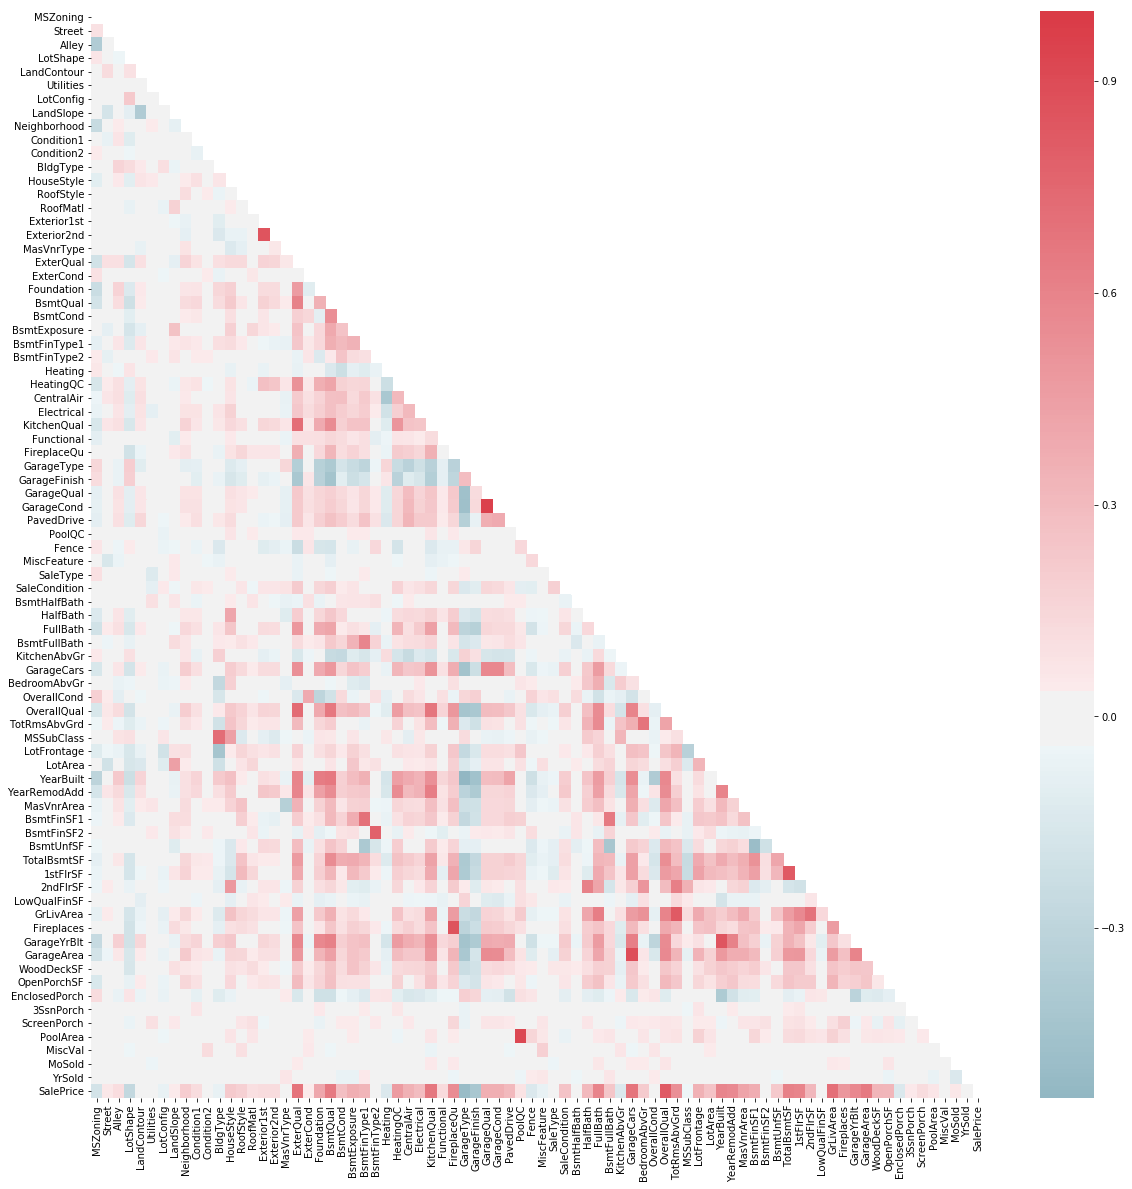

In [83]:
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.subplots(figsize=(20, 20))
hm = sns.heatmap(corrmat, cmap=cmap, mask=mask, center=0,
            xticklabels=corrmat.columns.values,
            yticklabels=corrmat.columns.values)

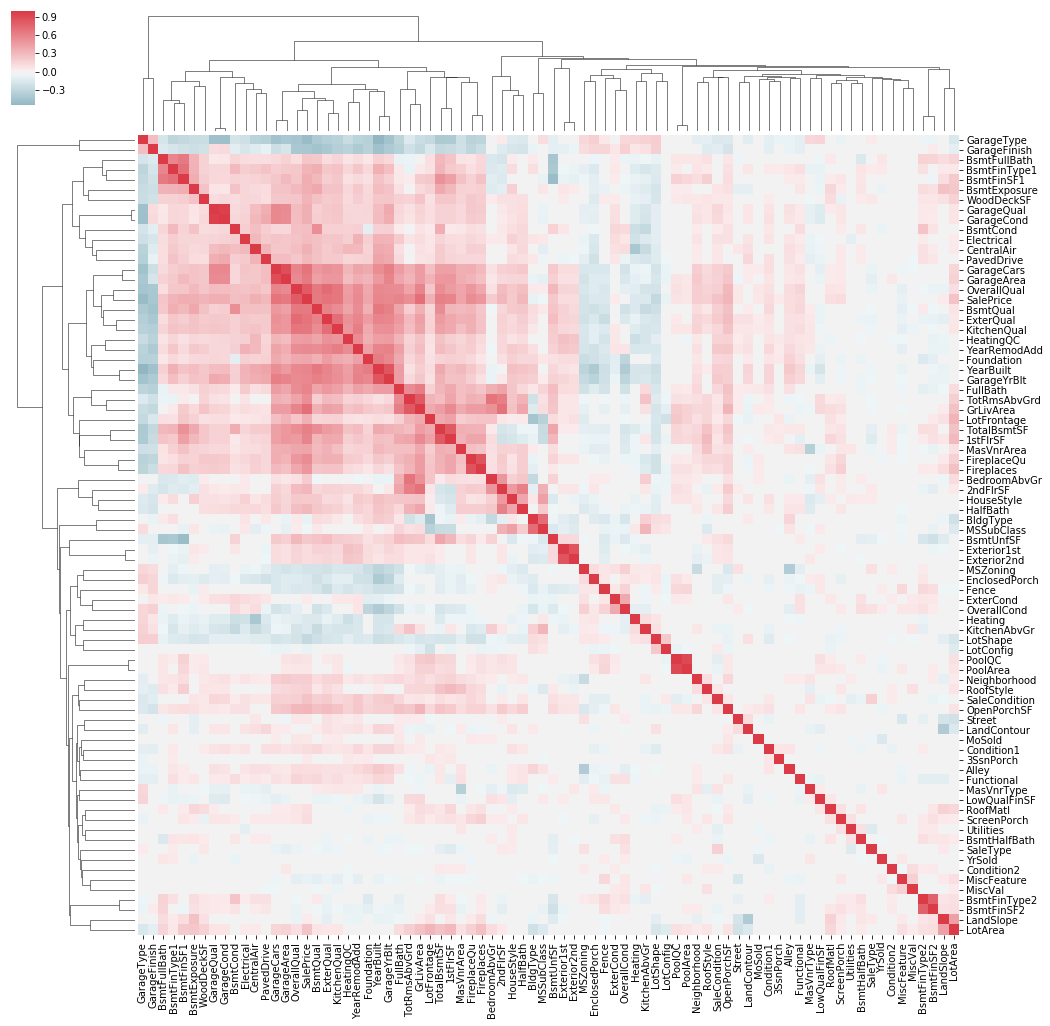

In [84]:
sns.clustermap(corrmat, cmap=cmap, center=0, figsize=(17, 17),
            xticklabels=corrmat.columns.values,
            yticklabels=corrmat.columns.values)

In [146]:
def corr_mat_feat(df, feat, k_pos=5, k_neg=5, corrmat=None, cmap=None):
    if corrmat is None:
        corrmat = df.corr()
    if cmap is None:
        cmap = cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cols = list(corrmat.nlargest(k_pos, feat)[feat].index) + list(corrmat.nsmallest(k_neg, feat)[feat].index)
    cols = list(set(cols))
    cols_labels = cols
    cm = df[cols].corr()
    sns.clustermap(cm, cbar=True, annot=True, square=True, cmap=cmap, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols_labels, xticklabels=cols_labels, center=0)
    
def corr_mat_feat_imp(df, feat, pipeline, target_feat, k_pos=5, k_neg=5, corrmat=None, cmap=None):
    if corrmat is None:
        corrmat = df.corr()
    if cmap is None:
        cmap = cmap = sns.diverging_palette(220, 10, as_cmap=True)
    feat_imp = get_features_importance(pipeline, df.drop(target_feat, axis=1))
    feat_imp[target_feat] = " "
    cols = list(corrmat.nlargest(k_pos, feat)[feat].index) + list(corrmat.nsmallest(k_neg, feat)[feat].index)
    cols = list(set(cols))
    cols_labels = [col+" "+str(feat_imp.loc[feat_imp.Feature == col, "Importance"].values) if col != target_feat else col for col in cols]
    cm = df[cols].corr()
    sns.clustermap(cm, cbar=True, annot=True, square=True, cmap=cmap, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols_labels, xticklabels=cols_labels, center=0)    

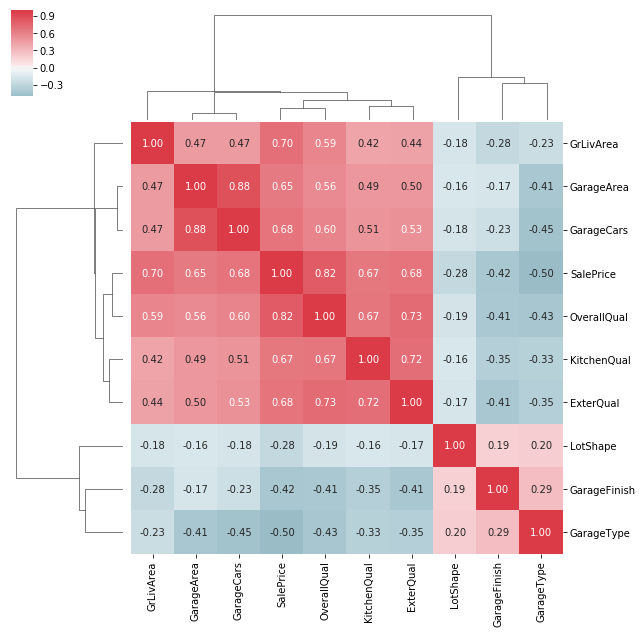

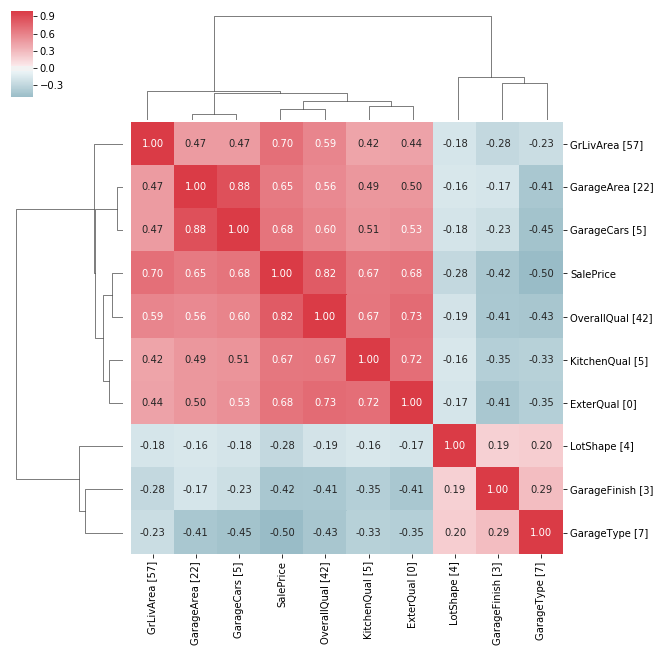

In [148]:
corr_mat_feat(df_extra, "SalePrice", k_pos=7, k_neg=3, corrmat=corrmat)
corr_mat_feat_imp(df_extra, "SalePrice", pipeline, "SalePrice", k_pos=7, k_neg=3, corrmat=corrmat)

In [151]:
def corr_mat_feat_2(df, feats, model=None, target_feat=None, corrmat=None, cmap=None):
    if corrmat is None:
        corrmat = df.corr()
    if cmap is None:
        cmap = cmap = sns.diverging_palette(220, 10, as_cmap=True)
    if model is not None:
        feat_imp = {feat: np.round(imp, 5) for feat, imp in zip(df.drop(target_feat, axis=1).columns.values, clf.best_estimator_.feature_importances_)}
    cols = feats
    if model is not None:
        cols_labels = [str(c)+"_"+str(feat_imp[c]) if c != target_feat else str(c) for c in cols]
    else:
        cols_labels = cols
    cm = df[cols].corr()
    sns.clustermap(cm, cbar=True, annot=True, square=True, cmap=cmap, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols_labels, xticklabels=cols_labels, center=0)
    
def corr_mat_group_feat(df, feats, corrmat=None, cmap=None):
    if corrmat is None:
        corrmat = df.corr()
    if cmap is None:
        cmap = cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cols = feats
    cols_labels = cols
    cm = df[cols].corr()
    sns.clustermap(cm, cbar=True, annot=True, square=True, cmap=cmap, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols_labels, xticklabels=cols_labels, center=0)
    
def corr_mat_group_feat_imp(df, feats, pipeline, target_feat, corrmat=None, cmap=None):
    if corrmat is None:
        corrmat = df.corr()
    if cmap is None:
        cmap = cmap = sns.diverging_palette(220, 10, as_cmap=True)
    feat_imp = get_features_importance(pipeline, df.drop(target_feat, axis=1))
    feat_imp[target_feat] = " "
    cols = feats
    cols_labels = [col+" "+str(feat_imp.loc[feat_imp.Feature == col, "Importance"].values) if col != target_feat else col for col in cols]
    cm = df[cols].corr()
    sns.clustermap(cm, cbar=True, annot=True, square=True, cmap=cmap, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols_labels, xticklabels=cols_labels, center=0)

# Garage variables

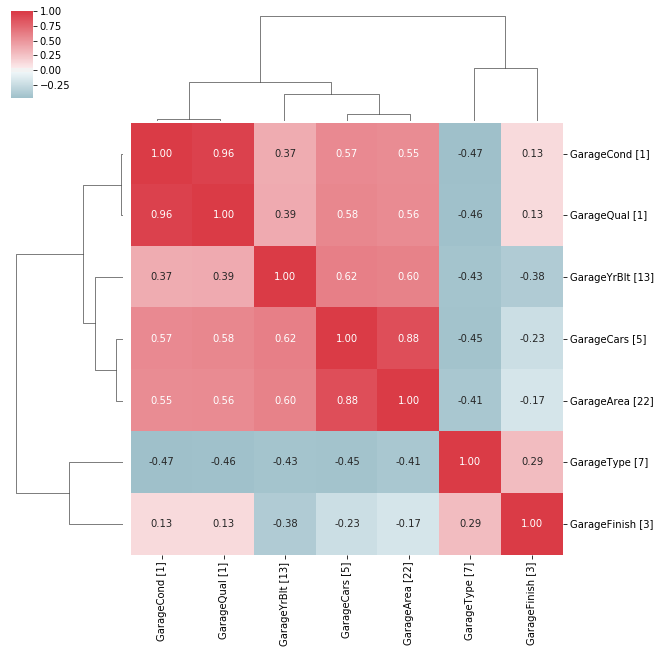

In [154]:
corr_mat_group_feat_imp(df_extra, ["GarageType", "GarageYrBlt", "GarageFinish", "GarageCars", "GarageArea", "GarageCond", "GarageQual"], pipeline, "SalePrice", corrmat=corrmat)

## GarageCond and GarageQual

In [164]:
print(category_inv_mapper["GarageCond"])
print(category_inv_mapper["GarageQual"])
inter = pdp.pdp_interact(pipeline, df_train, ['GarageCond', 'GarageQual'], num_grid_points=[10, 10])
pdp.pdp_interact_plot(inter, ['GarageCond', 'GarageQual'], center=True, plot_org_pts=True, plot_lines=True, frac_to_plot=0.5, x_quantile=True)
pdp.target_plot(df_extra, 'GarageCond', 'GarageCond', 'SalePrice')
pdp.target_plot(df_extra, 'GarageQual', 'GarageQual', 'SalePrice')

{'No_Garage': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
{'No_Garage': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}


ValueError: feature does not exist: GarageCond

In [156]:
print("baseline: ", score_baseline)
for feat in ["GarageCond", "GarageQual"]:
    df_sub = df_train.drop(feat, axis=1)
    pipeline.fit(df_sub, y)
    scores = get_cv_score(pipeline)
    print(feat+" RMSE: %0.5f (+/- %0.5f)" % (scores[0], scores[1]))

baseline:  [ 0.12747475]
GarageCond RMSE: 0.12727 (+/- 0.00973)
GarageQual RMSE: 0.12832 (+/- 0.00864)


In [157]:
dropped_cols = pd.DataFrame()
dropped_cols = dropped_cols.join(df_train["GarageCond"])

In [158]:
df_train.drop("GarageCond", axis=1, inplace=True)

In [159]:
pipeline.fit(df_train, y)
scores = get_cv_score(pipeline)
print("RMSE: %0.5f (+/- %0.5f)" % (scores[0], scores[1]))
baseline_score = scores[0]

RMSE: 0.12727 (+/- 0.00973)


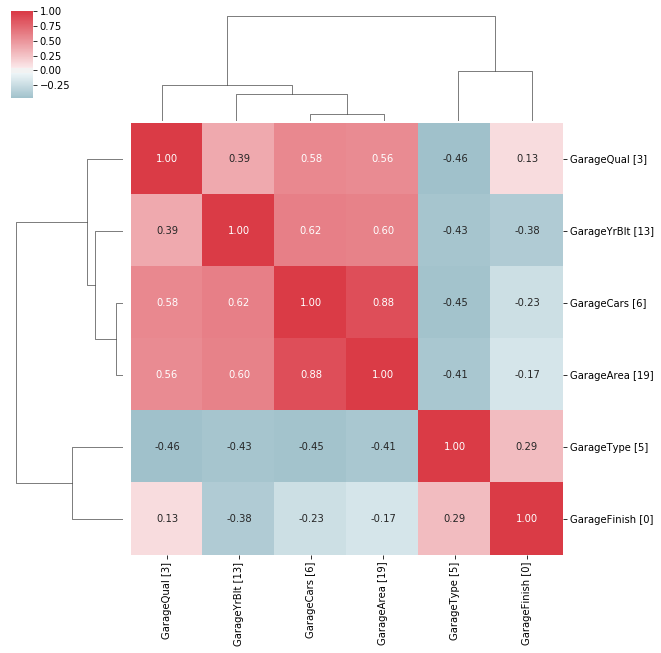

In [161]:
corr_mat_group_feat_imp(df_extra, ["GarageType", "GarageYrBlt", "GarageFinish", "GarageCars", "GarageArea", "GarageQual"], pipeline, "SalePrice", corrmat=corrmat)

## GarageArea and GarageCars

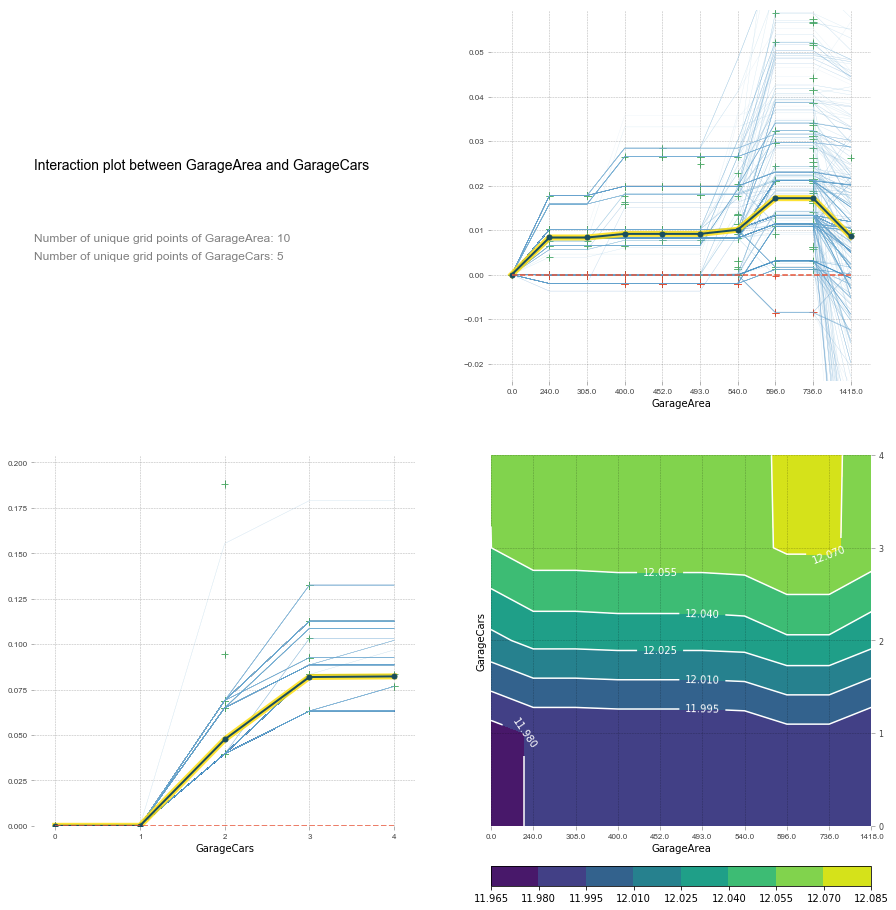

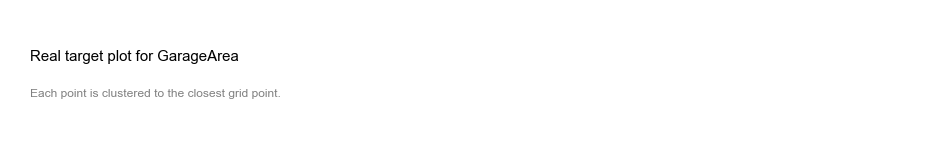

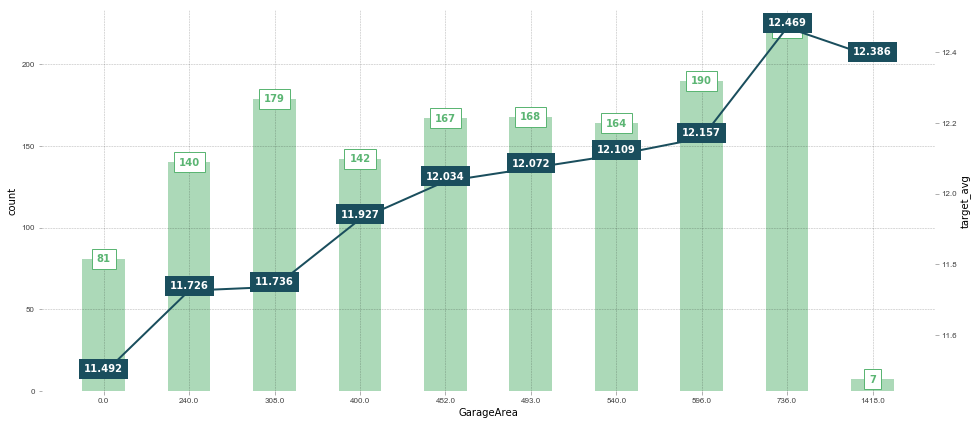

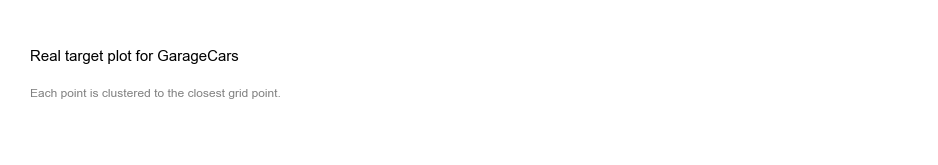

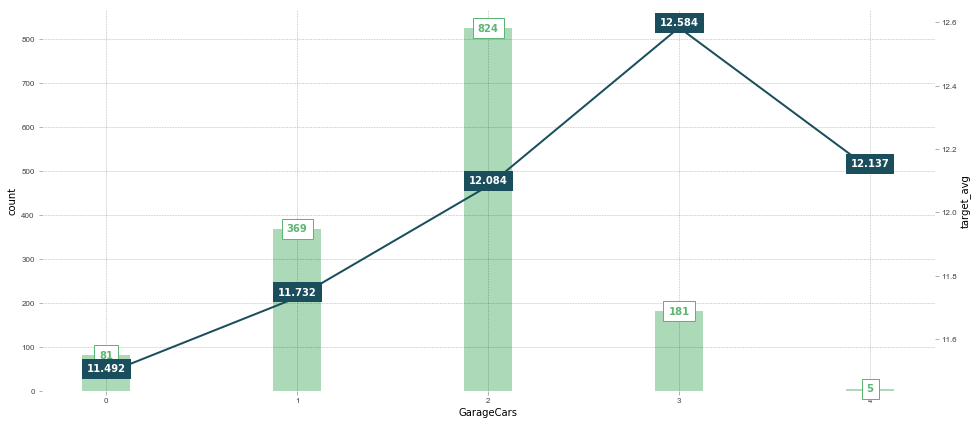

In [163]:
inter = pdp.pdp_interact(pipeline, df_train, ['GarageArea', 'GarageCars'], num_grid_points=[10, 10])
pdp.pdp_interact_plot(inter, ['GarageArea', 'GarageCars'], center=True, plot_org_pts=True, plot_lines=True, frac_to_plot=0.5, x_quantile=True)
pdp.target_plot(df_extra, 'GarageArea', 'GarageArea', 'SalePrice')
pdp.target_plot(df_extra, 'GarageCars', 'GarageCars', 'SalePrice')

In [165]:
print("baseline: ", baseline_score)
for feat in ["GarageArea", "GarageCars"]:
    df_sub = df_train.drop(feat, axis=1)
    pipeline.fit(df_sub, y)
    scores = get_cv_score(pipeline)
    print(feat+" RMSE: %0.5f (+/- %0.5f)" % (scores[0], scores[1]))

baseline:  [ 0.12727198]
GarageArea RMSE: 0.12711 (+/- 0.00871)
GarageCars RMSE: 0.12847 (+/- 0.00710)


In [169]:
dropped_cols = dropped_cols.join(df_train["GarageArea"])

In [170]:
df_train.drop("GarageArea", axis=1, inplace=True)

In [171]:
pipeline.fit(df_train, y)
scores = get_cv_score(pipeline)
print("RMSE: %0.5f (+/- %0.5f)" % (scores[0], scores[1]))
baseline_score = scores[0]

RMSE: 0.12830 (+/- 0.00940)


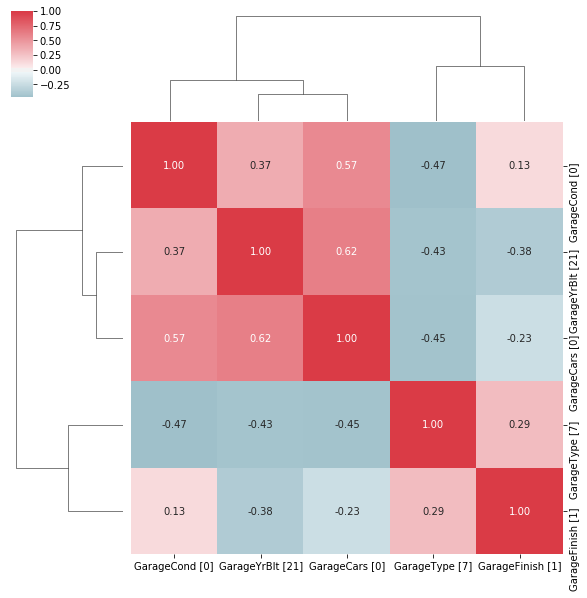

In [172]:
corr_mat_group_feat_imp(df_extra, ["GarageType", "GarageYrBlt", "GarageFinish", "GarageCars", "GarageCond"], pipeline, "SalePrice", corrmat=corrmat)

# Pool variables

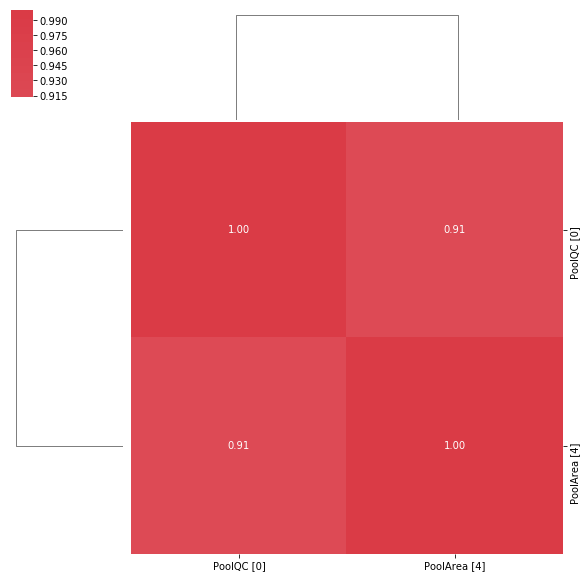

In [173]:
corr_mat_group_feat_imp(df_extra, ["PoolQC", "PoolArea"], pipeline, "SalePrice", corrmat=corrmat)

{'No_Pool': 0, 'Fa': 1, 'Gd': 2, 'Ex': 3}


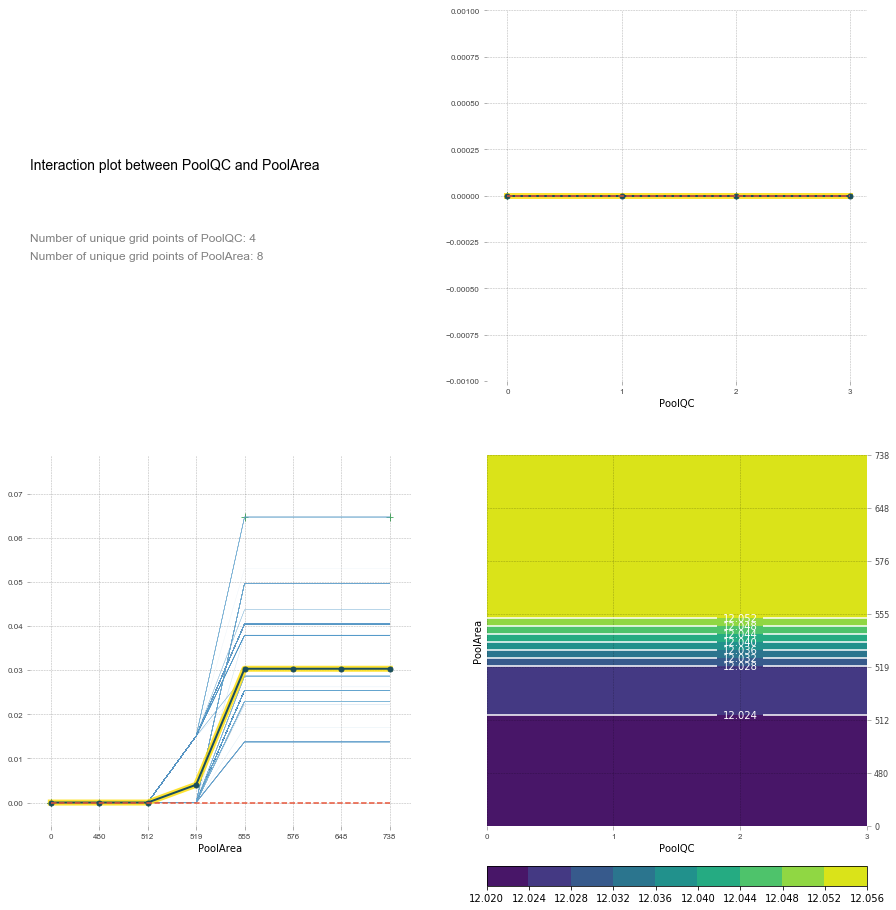

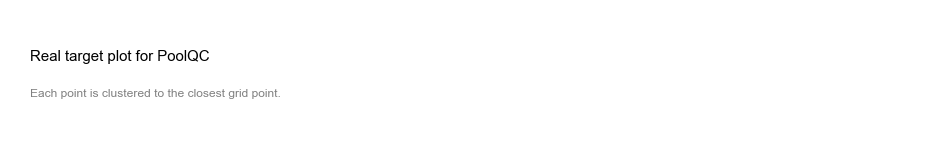

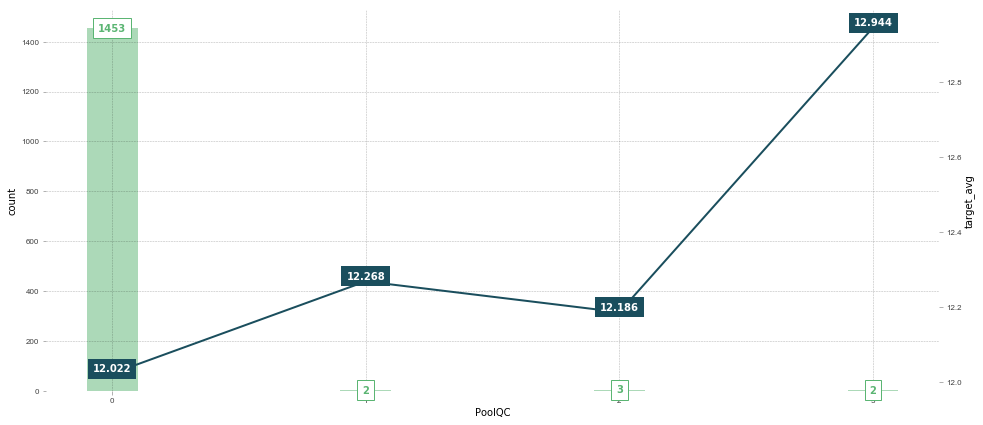

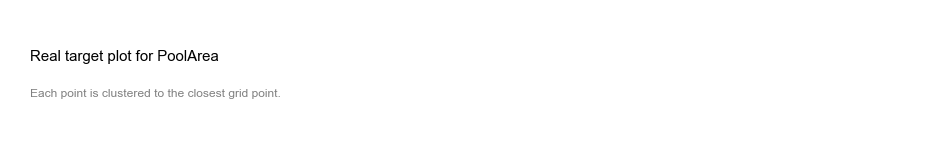

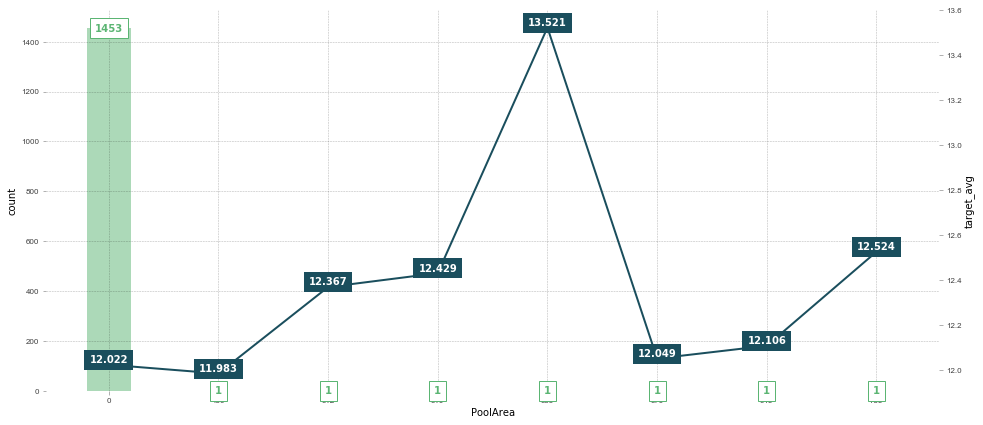

In [174]:
print(category_inv_mapper["PoolQC"])
inter = pdp.pdp_interact(pipeline, df_train, ['PoolQC', 'PoolArea'], num_grid_points=[10, 10])
pdp.pdp_interact_plot(inter, ['PoolQC', 'PoolArea'], center=True, plot_org_pts=True, plot_lines=True, frac_to_plot=0.5, x_quantile=True)
pdp.target_plot(df_train.join(df_extra["SalePrice"]), 'PoolQC', 'PoolQC', 'SalePrice')
pdp.target_plot(df_train.join(df_extra["SalePrice"]), 'PoolArea', 'PoolArea', 'SalePrice')

In [175]:
df_train["has_pool"] = df_train["PoolQC"] != 3

In [176]:
pipeline.fit(df_train, y)
scores = get_cv_score(pipeline)
print("RMSE: %0.5f (+/- %0.5f)" % (scores[0], scores[1]))

RMSE: 0.12830 (+/- 0.00940)


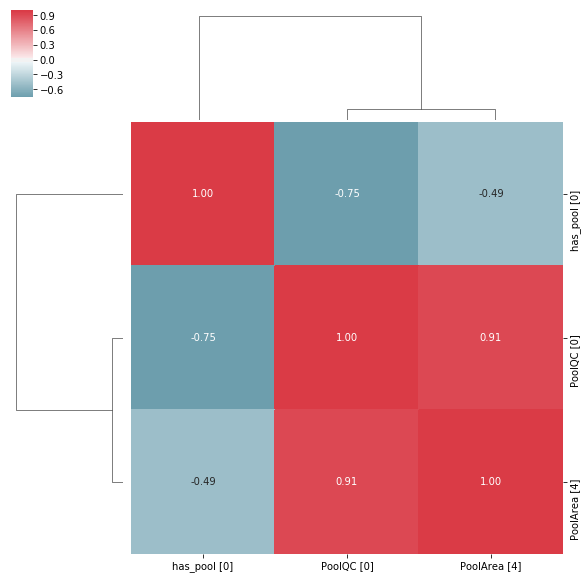

In [177]:
corr_mat_group_feat_imp(df_train.join(df_extra["SalePrice"]), ["PoolQC", "PoolArea", "has_pool"], pipeline, "SalePrice")

In [179]:
print("baseline: ", baseline_score)
for feat in ["PoolQC", "PoolArea", "has_pool"]:
    df_sub = df_train.drop(["PoolQC", "PoolArea", "has_pool"], axis=1)
    df_sub = df_sub.join(df_train[feat])
    pipeline.fit(df_sub, y)
    scores = get_cv_score(pipeline)
    print(feat+" RMSE: %0.5f (+/- %0.5f)" % (scores[0], scores[1]))

baseline:  [ 0.12830486]
PoolQC RMSE: 0.12856 (+/- 0.00950)
PoolArea RMSE: 0.12830 (+/- 0.00940)
has_pool RMSE: 0.12855 (+/- 0.00955)


In [180]:
dropped_cols = dropped_cols.join(df_train[["PoolQC", "has_pool"]])

In [181]:
df_train.drop(["PoolQC", "has_pool"], axis=1, inplace=True)

In [182]:
pipeline.fit(df_train, y)
scores = get_cv_score(pipeline)
print("RMSE: %0.5f (+/- %0.5f)" % (scores[0], scores[1]))
baseline_score = scores[0]

RMSE: 0.12830 (+/- 0.00940)


# Quality variables
## OverallQual

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9}


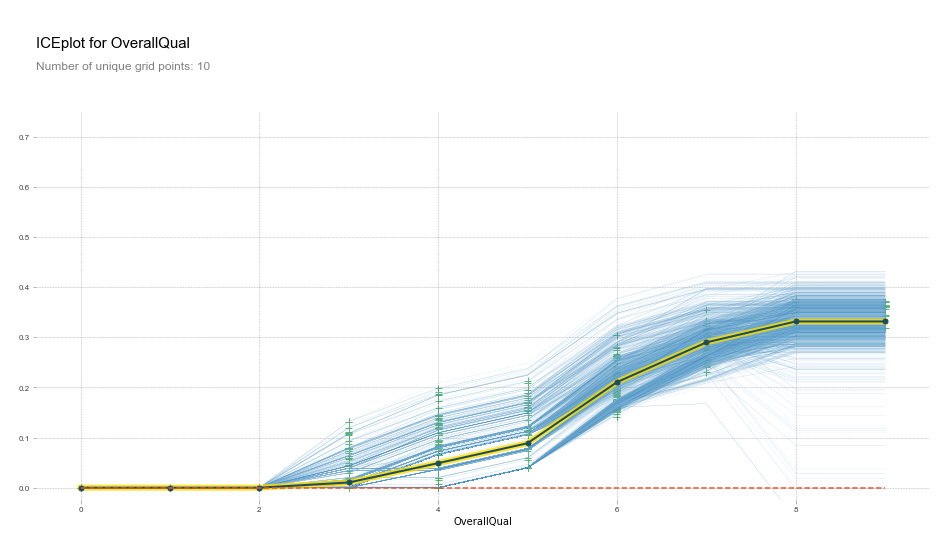

In [200]:
print(category_inv_mapper["OverallQual"])
isolate = pdp.pdp_isolate(pipeline, df_train, "OverallQual")
pdp.pdp_plot(isolate, 'OverallQual', plot_org_pts=True, plot_lines=True, frac_to_plot=1)

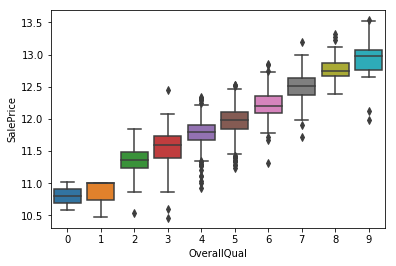

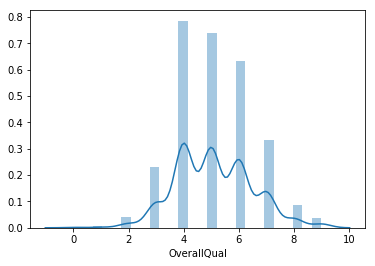

In [724]:
sns.boxplot(x="OverallQual", y="SalePrice", data=df_train.join(df_extra["SalePrice"]))
plt.show()
sns.distplot(df_train["OverallQual"])

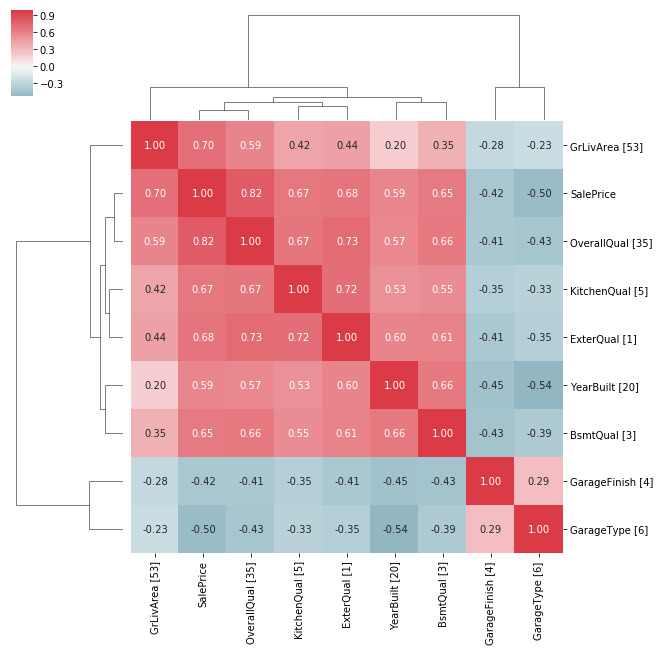

In [219]:
corr_mat_feat_imp(df_train.join(df_extra["SalePrice"]), "OverallQual", pipeline, "SalePrice", k_pos=7, k_neg=2)

## Fence

{'No_Fence': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}


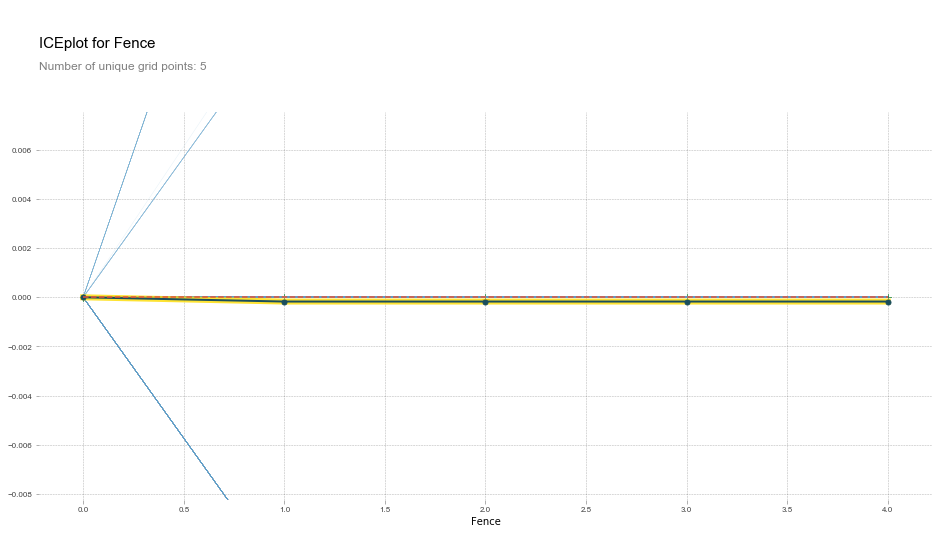

In [203]:
print(category_inv_mapper["Fence"])
isolate = pdp.pdp_isolate(pipeline, df_train, "Fence")
pdp.pdp_plot(isolate, "Fence", plot_org_pts=True, plot_lines=True, frac_to_plot=1)

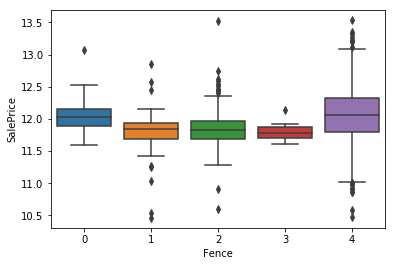

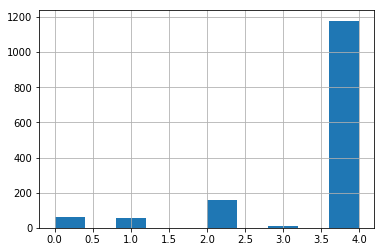

In [344]:
sns.boxplot(x="Fence", y="SalePrice", data=df_train.join(df_extra["SalePrice"]))
plt.show()
df_train["Fence"].hist()

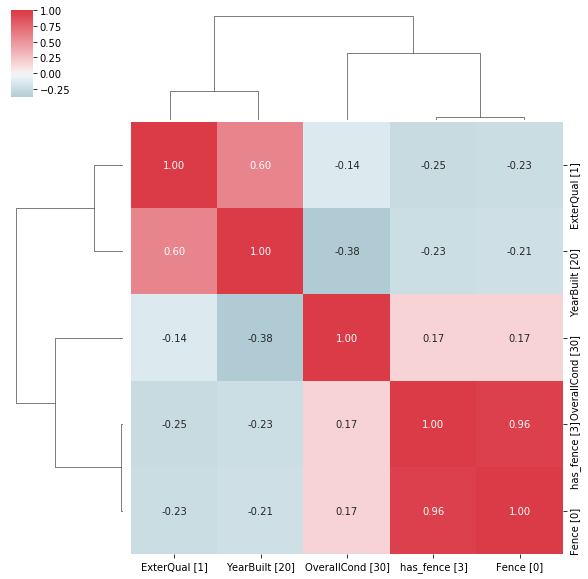

In [235]:
corr_mat_feat_imp(df_train.join(df_extra["SalePrice"]), "Fence", pipeline, "SalePrice", k_pos=3, k_neg=2)

It is only the fact that a house has a fence or not that influence the price. The type of the fence is meaningless, so let create a "has_fence" feature and check if it improve the model.

In [233]:
df_train["has_fence"] = df_train["Fence"] != 0

In [307]:
df_test["has_fence"] = (df_test["Fence"] != 0).astype(int)
df_test.drop("Fence", axis=1, inplace=True)

In [236]:
dropped_cols["Fence"] = df_train["Fence"]

In [237]:
df_train.drop("Fence", axis=1, inplace=True)

## ExterQual

In [254]:
print(category_inv_mapper["ExterQual"])
isolate = pdp.pdp_isolate(pipeline, df_train, "ExterQual")
pdp.pdp_plot(isolate, "ExterQual", plot_org_pts=True, plot_lines=True, frac_to_plot=1)

{'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}


ValueError: feature does not exist: ExterQual

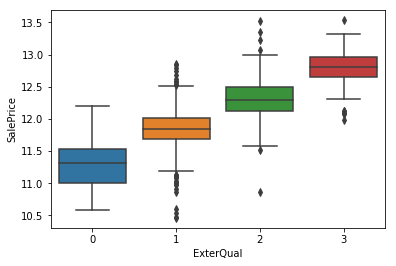

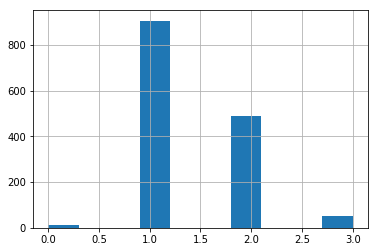

In [721]:
sns.boxplot(x="ExterQual", y="SalePrice", data=df_train.join(df_extra["SalePrice"]))
plt.show()
df_train["ExterQual"].hist()

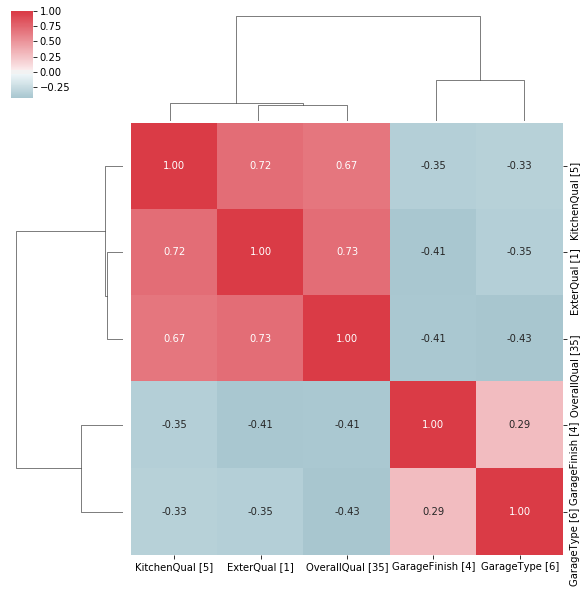

In [220]:
corr_mat_feat_imp(df_train.join(df_extra["SalePrice"]), "ExterQual", pipeline, "SalePrice", k_pos=3, k_neg=2)

From the partial dependence plot we deduce than we can regroup "FA", "TA" under one category and "Gd", "Ex" unde another. We create a new feature "ExtQual_clean" compose of two categories "bad", "good".

In [240]:
df_train["ExtQual_clean"] = (df_train["ExterQual"] > 1).astype(int)

In [308]:
df_test["ExtQual_clean"] = (df_test["ExterQual"] > 1).astype(int)
df_test.drop("ExterQual", axis=1, inplace=True)

In [241]:
dropped_cols["ExterQual"] = df_train["ExterQual"]

In [242]:
df_train.drop("ExterQual", axis=1, inplace=True)

In [266]:
pipeline.fit(df_train, y)
scores = get_cv_score(pipeline)
print("RMSE: %0.5f (+/- %0.5f)" % (scores[0], scores[1]))

RMSE: 0.12717 (+/- 0.00803)


In [264]:
df_train["has_fence"] = df_train["has_fence"].astype(int)
df_train["ExtQual_clean"] = df_train["ExtQual_clean"].astype(int)

## BsmtQual

{'No_Basement': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}


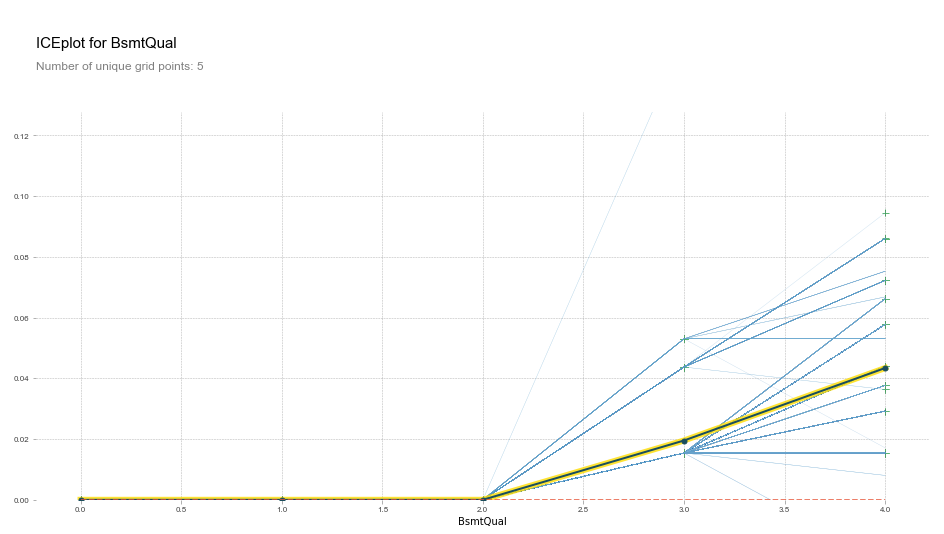

In [267]:
print(category_inv_mapper["BsmtQual"])
isolate = pdp.pdp_isolate(pipeline, df_train, "BsmtQual")
pdp.pdp_plot(isolate, "BsmtQual", plot_org_pts=True, plot_lines=True, frac_to_plot=1)

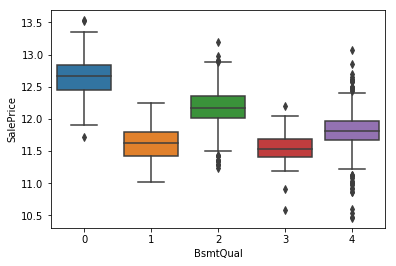

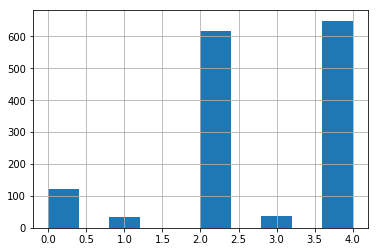

In [354]:
sns.boxplot(x="BsmtQual", y="SalePrice", data=df_train.join(df_extra["SalePrice"]))
plt.show()
df_train["BsmtQual"].hist()

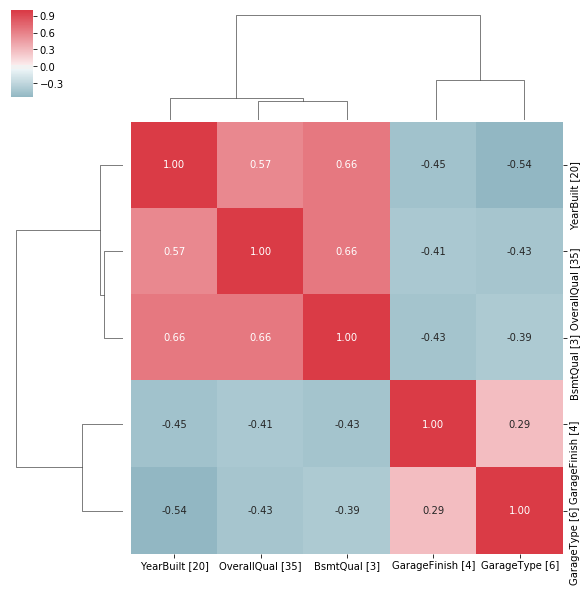

In [268]:
corr_mat_feat_imp(df_train.join(df_extra["SalePrice"]), "BsmtQual", pipeline, "SalePrice", k_pos=3, k_neg=2)

## HeatingQC

{'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}


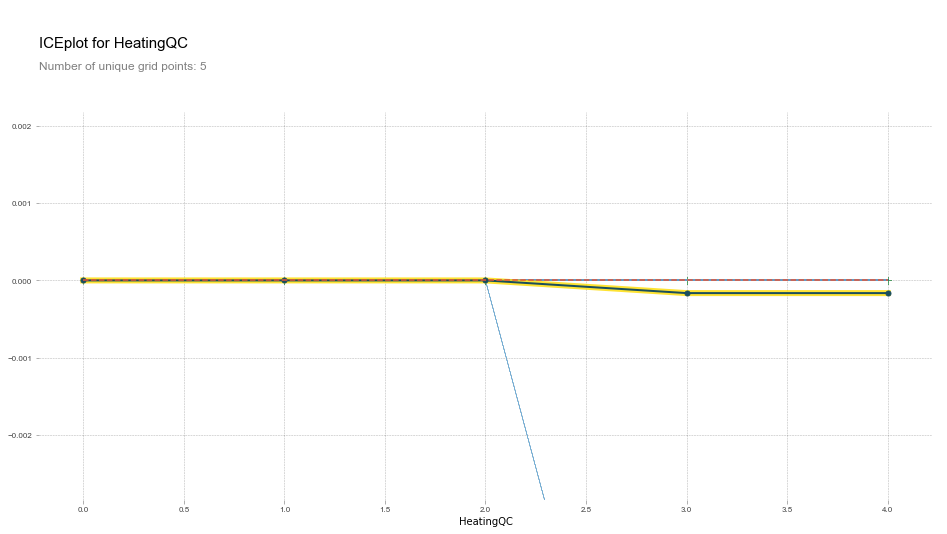

In [224]:
print(category_inv_mapper["HeatingQC"])
isolate = pdp.pdp_isolate(pipeline, df_train, "HeatingQC")
pdp.pdp_plot(isolate, "HeatingQC", plot_org_pts=True, plot_lines=True, frac_to_plot=1)

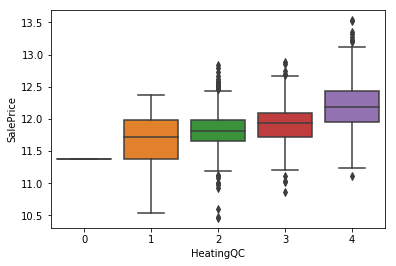

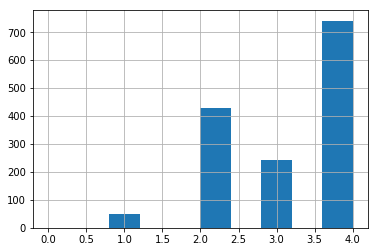

In [728]:
sns.boxplot(x="HeatingQC", y="SalePrice", data=df_train.join(df_extra["SalePrice"]))
plt.show()
df_train["HeatingQC"].hist()

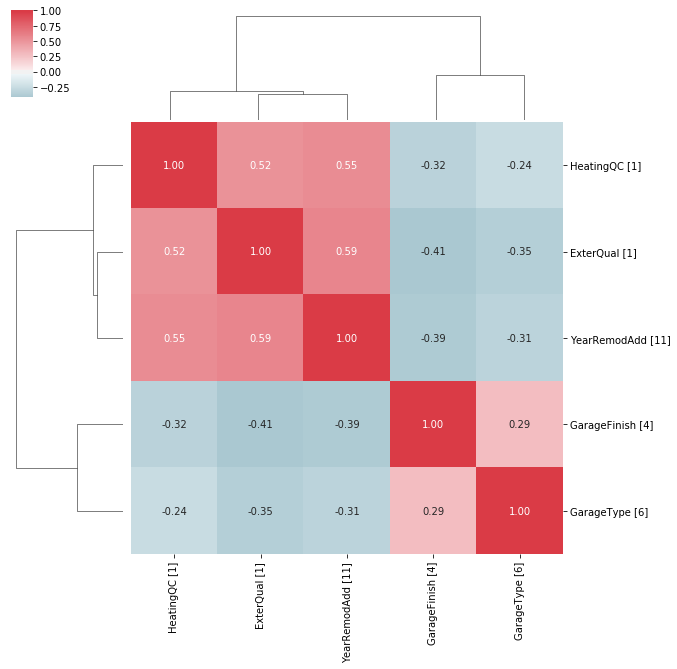

In [225]:
corr_mat_feat_imp(df_train.join(df_extra["SalePrice"]), "HeatingQC", pipeline, "SalePrice", k_pos=3, k_neg=2)

In [316]:
df_train["HeatingQC_clean"] = (df_train["HeatingQC"] > 2).astype(int)

In [310]:
df_test["HeatingQC_clean"] = (df_test["HeatingQC"]> 2).astype(int)
df_test.drop("HeatingQC", axis=1, inplace=True)

In [317]:
dropped_cols["HeatingQC"] = df_train["HeatingQC"]

In [318]:
df_train.drop("HeatingQC", axis=1, inplace=True)

In [273]:
pipeline.fit(df_train, y)
scores = get_cv_score(pipeline)
print("RMSE: %0.5f (+/- %0.5f)" % (scores[0], scores[1]))

RMSE: 0.12717 (+/- 0.00803)


## KitchenQual

{'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}


Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x1c1e2a1780>>
Traceback (most recent call last):
  File "/Users/bastien/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


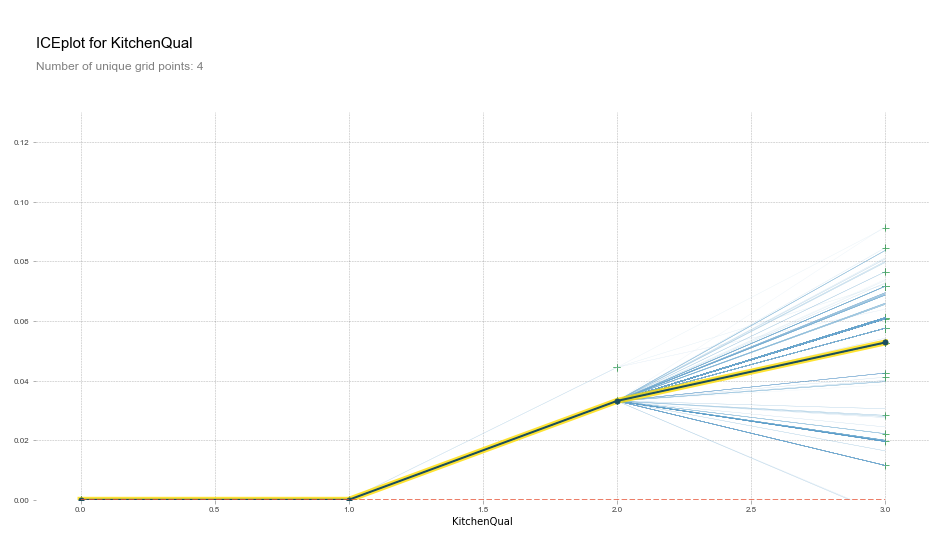

In [274]:
print(category_inv_mapper["KitchenQual"])
isolate = pdp.pdp_isolate(pipeline, df_train, "KitchenQual")
pdp.pdp_plot(isolate, "KitchenQual", plot_org_pts=True, plot_lines=True, frac_to_plot=1)

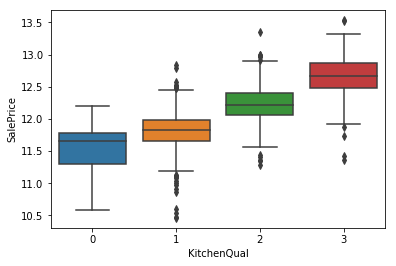

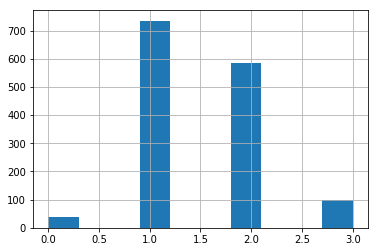

In [731]:
sns.boxplot(x="KitchenQual", y="SalePrice", data=df_train.join(df_extra["SalePrice"]))
plt.show()
df_train["KitchenQual"].hist()

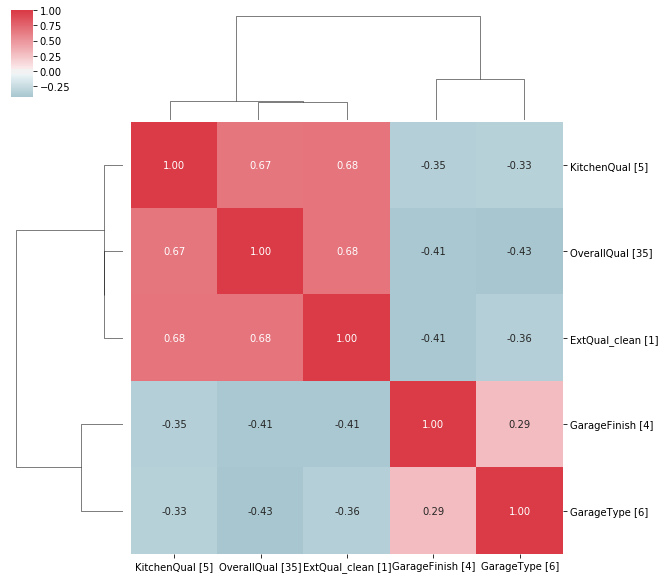

In [275]:
corr_mat_feat_imp(df_train.join(df_extra["SalePrice"]), "KitchenQual", pipeline, "SalePrice", k_pos=3, k_neg=2)

## FireplaceQu

In [228]:
print(category_inv_mapper["FireplaceQu"])
isolate = pdp.pdp_isolate(pipeline, df_train, "FireplaceQu")
pdp.pdp_plot(isolate, "FireplaceQu", plot_org_pts=True, plot_lines=True, frac_to_plot=1)

{'No_Fireplace': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}


ValueError: feature does not exist: FireplaceQu

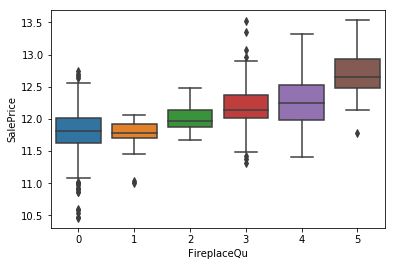

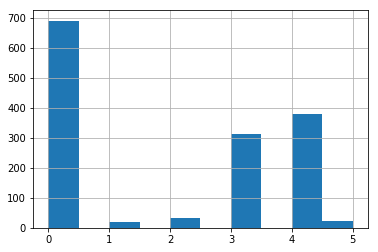

In [735]:
sns.boxplot(x="FireplaceQu", y="SalePrice", data=df_train.join(df_extra["SalePrice"]))
plt.show()
df_train["FireplaceQu"].hist()

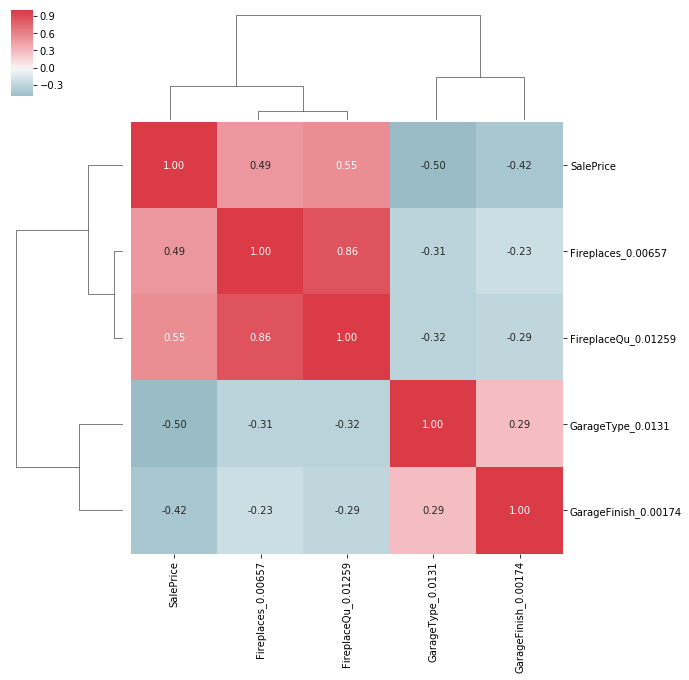

In [742]:
corr_mat_feat_imp(df_train.join(df_extra["SalePrice"]), "FireplaceQu", pipeline, "SalePrice", k_pos=3, k_neg=2)

# Fireplaces and FireplaceQu

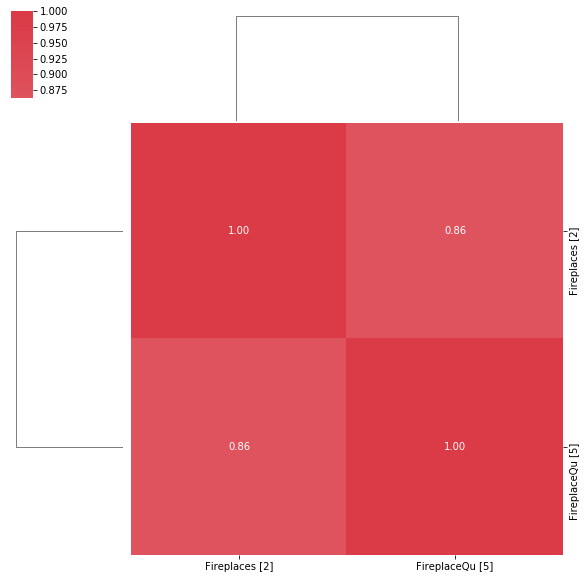

In [183]:
corr_mat_group_feat_imp(df_train.join(df_extra["SalePrice"]), ["Fireplaces", "FireplaceQu"], pipeline, "SalePrice")

{'No_Fireplace': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}


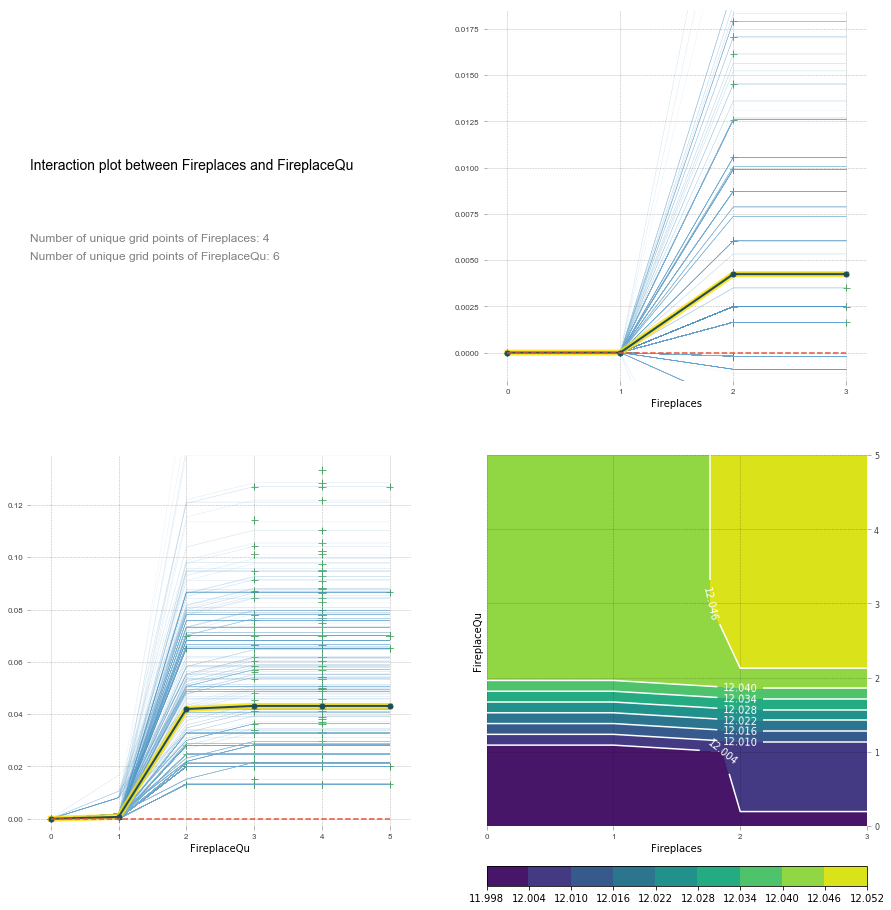

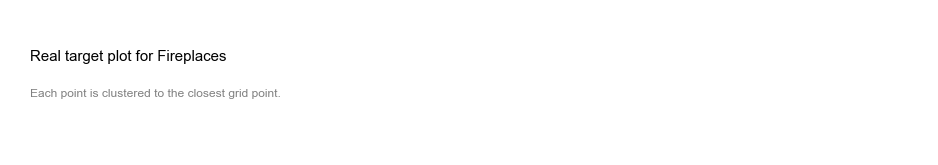

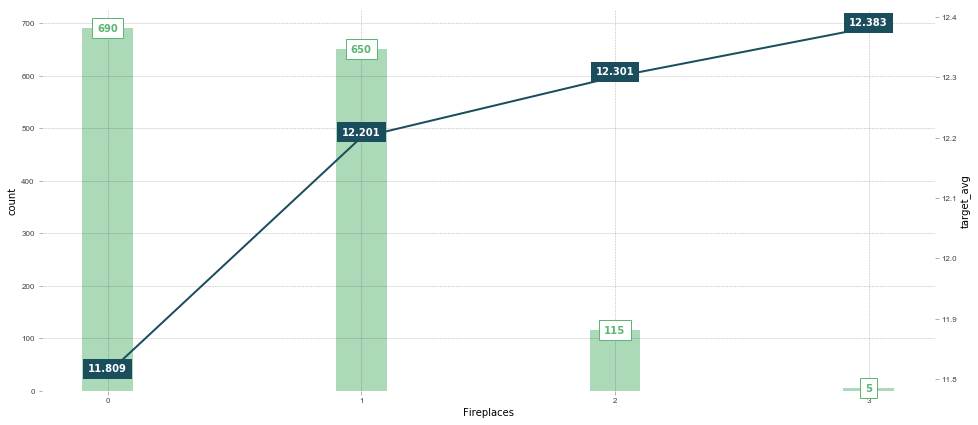

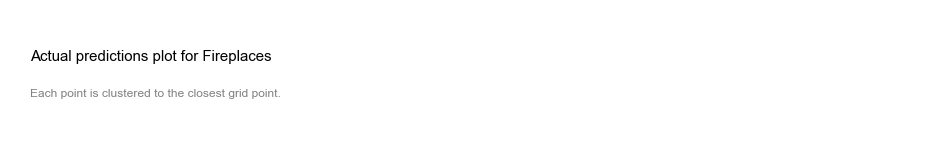

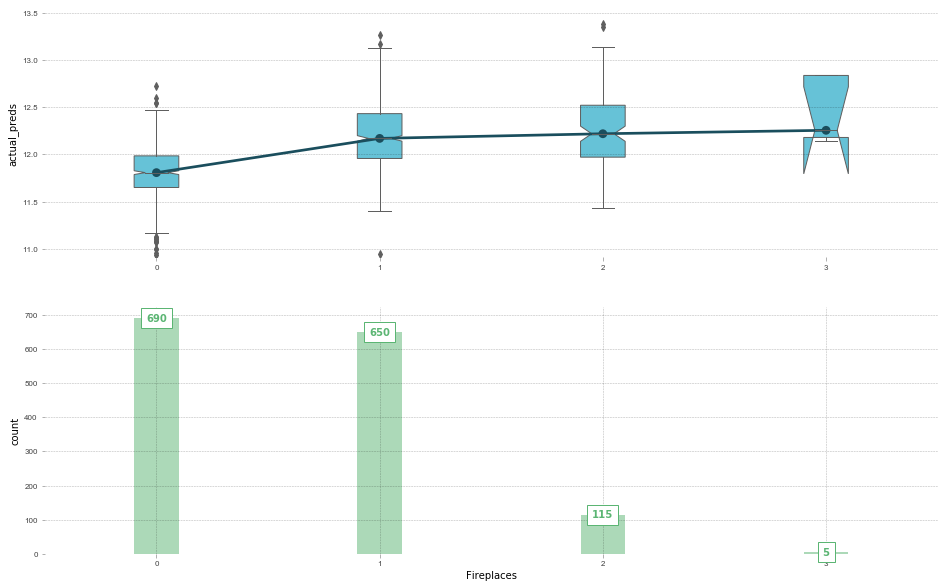

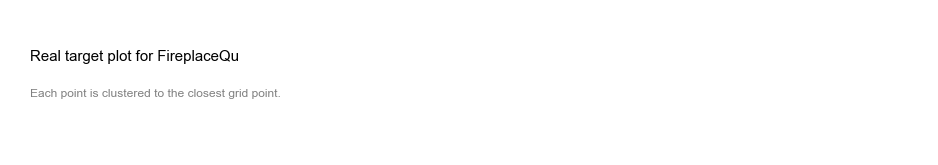

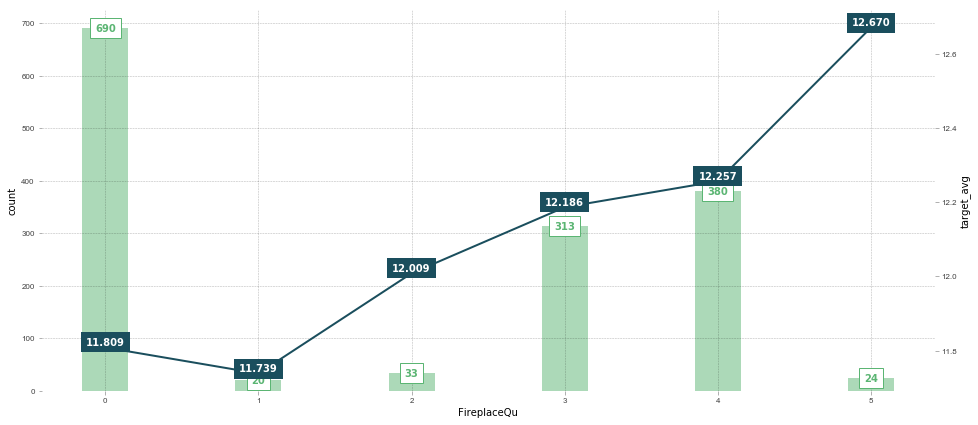

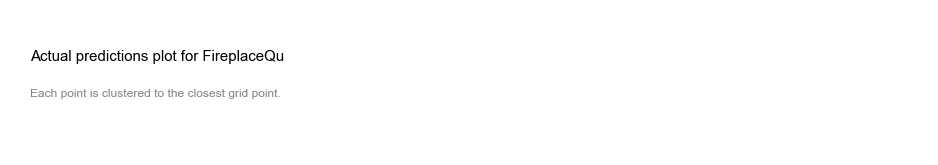

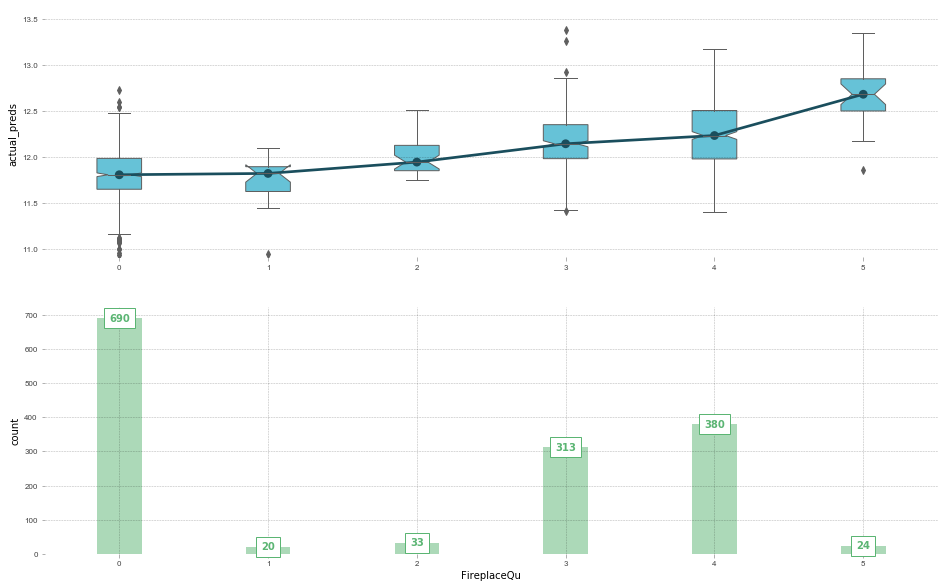

In [184]:
print(category_inv_mapper["FireplaceQu"])
inter = pdp.pdp_interact(pipeline, df_train, ['Fireplaces', 'FireplaceQu'], num_grid_points=[10, 10])
pdp.pdp_interact_plot(inter, ['Fireplaces', 'FireplaceQu'], center=True, plot_org_pts=True, plot_lines=True, frac_to_plot=0.5, x_quantile=True)
pdp.target_plot(df_train.join(df_extra["SalePrice"]), 'Fireplaces', 'Fireplaces', 'SalePrice')

In [186]:
# We see that for the feature fireplace the price is impacted by having at least one fireplace.
# Having more than one does not change much the price.
# However the faeture FireplaceQu already contain this info. So we can drop fireplaces.
print("baseline: ", baseline_score)
for feat in ["Fireplaces", "FireplaceQu"]:
    df_sub = df_train.drop(feat, axis=1)
    pipeline.fit(df_sub, y)
    scores = get_cv_score(pipeline)
    print(feat+" RMSE: %0.5f (+/- %0.5f)" % (scores[0], scores[1]))

baseline:  [ 0.12830486]
Fireplaces RMSE: 0.12909 (+/- 0.00956)
FireplaceQu RMSE: 0.12713 (+/- 0.00804)


In [187]:
dropped_cols = dropped_cols.join(df_train["FireplaceQu"])

In [188]:
df_train.drop("FireplaceQu", axis=1, inplace=True)

In [311]:
df_test.drop("FireplaceQu", axis=1, inplace=True)

In [189]:
pipeline.fit(df_train, y)
scores = get_cv_score(pipeline)
print("RMSE: %0.5f (+/- %0.5f)" % (scores[0], scores[1]))
baseline_score = scores[0]

RMSE: 0.12713 (+/- 0.00804)


# Basement variables

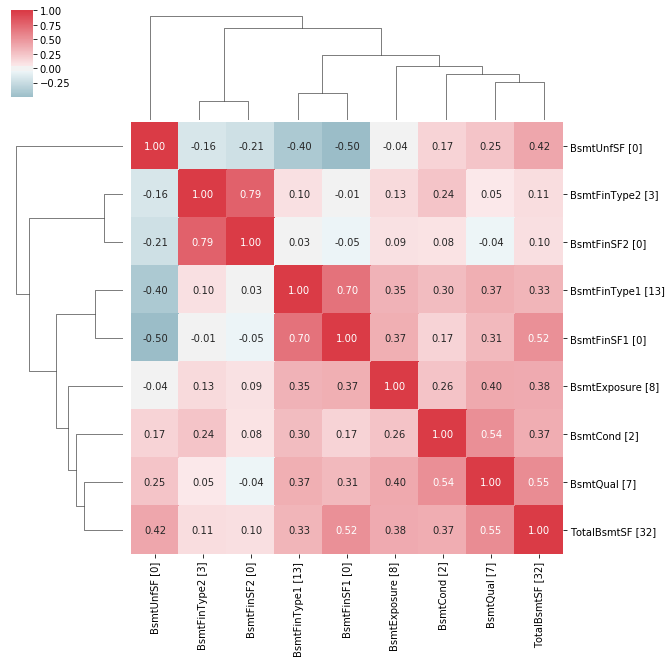

In [286]:
corr_mat_group_feat_imp(df_train.join(df_extra["SalePrice"]), ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"], pipeline, "SalePrice")

In [278]:
df_train["BsmtSF"] = df_train["BsmtUnfSF"]+df_train["BsmtFinSF2"]+df_train["BsmtFinSF1"]

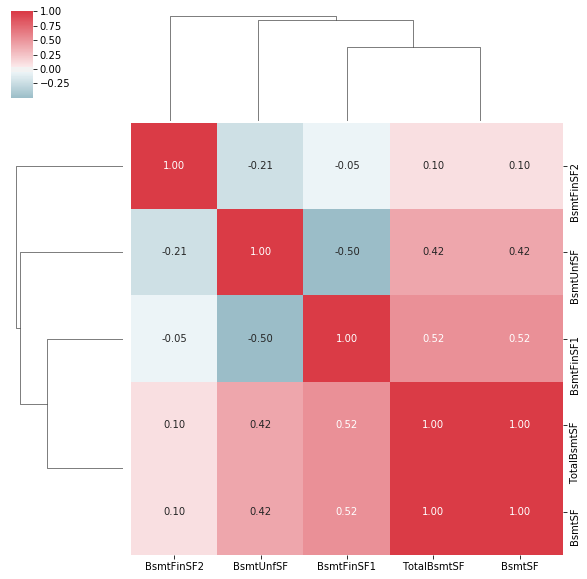

In [279]:
corr_mat_group_feat(df_train.join(df_extra["SalePrice"]), ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtSF"])

We see that "TotalBsmtSF" is identical to "BsmtSF", which mean that "TotalBsmtSF" is exactly the sum of "BsmtUnSF", "BsmtFinSF1", and "BsmtFinSF2".
Let see if it is better to keep the total or the 3 features.

In [280]:
df_train.drop("BsmtSF", axis=1, inplace=True)

In [283]:
print("baseline: ", baseline_score)
for feat in ["TotalBsmtSF", ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF"]]:
    df_sub = df_train.drop(feat, axis=1)
    pipeline.fit(df_sub, y)
    scores = get_cv_score(pipeline)
    print(" RMSE: %0.5f (+/- %0.5f)" % (scores[0], scores[1]))

baseline:  [ 0.12713056]
 RMSE: 0.12920 (+/- 0.00944)
 RMSE: 0.12842 (+/- 0.00974)


In [287]:
df_train.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'PavedDrive', 'MiscFeature',
       'SaleType', 'SaleCondition', 'BsmtHalfBath', 'HalfBath', 'FullBath',
       'BsmtFullBath', 'KitchenAbvGr', 'BedroomAbvGr', 'OverallCond',
       'OverallQual', 'TotRmsAbvGrd', 'MSSubClass', 'LotFrontage', 'LotArea',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'Fireplaces', 'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF',
       

In [296]:
df_train[["LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "PoolArea"]].skew()

LotArea          12.207688
MasVnrArea        2.677616
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
PoolArea         14.828374
dtype: float64

In [320]:
df_train2 = df_train.copy()

In [321]:
for c in ["LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "PoolArea"]:
    df_train2[c]= np.log1p(df_train2[c])

In [322]:
df_train2[["LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "PoolArea"]].skew()

LotArea          -0.137404
MasVnrArea        0.503532
BsmtFinSF1       -0.618410
BsmtFinSF2        2.523694
WoodDeckSF        0.153537
OpenPorchSF      -0.023397
EnclosedPorch     2.112275
PoolArea         14.363102
dtype: float64

In [323]:
pipeline.fit(df_train2, y)
scores = get_cv_score(pipeline)
print(" RMSE: %0.5f (+/- %0.5f)" % (scores[0], scores[1]))

 RMSE: 0.12714 (+/- 0.00714)


In [312]:
df_test2 = df_test.copy()

In [313]:
for c in ["LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "PoolArea"]:
    df_test2[c]= np.log1p(df_test2[c])

In [324]:
preds = pipeline.predict(df_test2[df_train.columns])

In [325]:
pd.DataFrame({"Id":df_test["Id"] , "SalePrice":np.exp(preds)-1}).to_csv("data/sub_xbg2.csv", index=False)

In [328]:
show_weights(pipeline.named_steps["model"].best_estimator_.get_booster())

Weight,Feature
0.2854,ExtQual_clean
0.1041,BsmtQual
0.0792,KitchenQual
0.0635,GarageType
0.0524,OverallQual
0.0481,TotalBsmtSF
0.0481,Fireplaces
0.0411,GrLivArea
0.0302,GarageQual
0.0267,CentralAir


{'No_Basement': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1d6aab00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c2270a0f0>]], dtype=object)

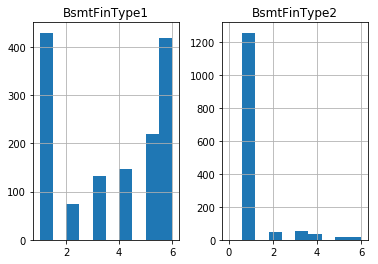

In [841]:
print(category_inv_mapper["BsmtFinType2"])
df_train.loc[df_train.BsmtFinType1 > 0, ["BsmtFinType1", "BsmtFinType2"]].hist()

{'No_Basement': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}


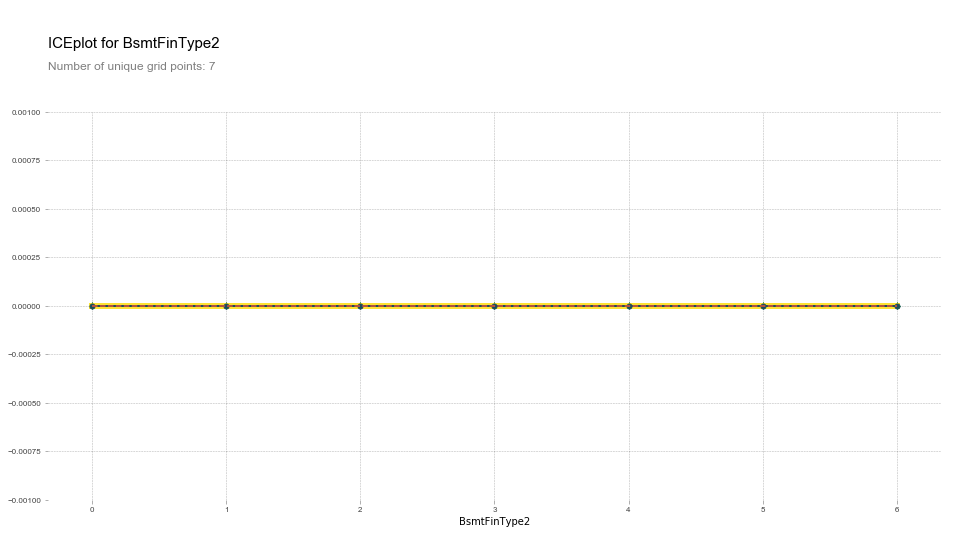

In [230]:
print(category_inv_mapper["BsmtFinType2"])
isolate = pdp.pdp_isolate(pipeline, df_train, "BsmtFinType2")
pdp.pdp_plot(isolate, "BsmtFinType2", plot_org_pts=True, plot_lines=True, frac_to_plot=1)

{'No_Basement': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}


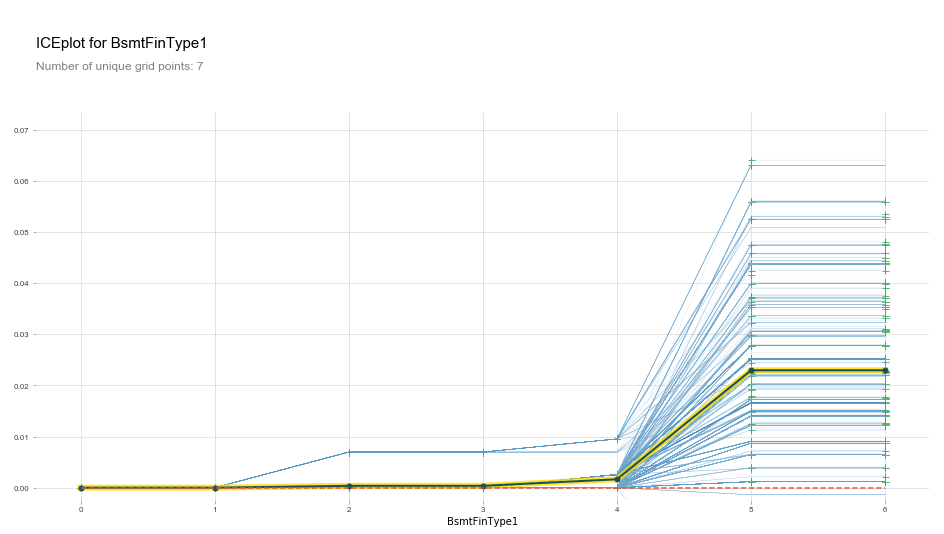

In [231]:
print(category_inv_mapper["BsmtFinType1"])
isolate = pdp.pdp_isolate(pipeline, df_train, "BsmtFinType1")
pdp.pdp_plot(isolate, "BsmtFinType1", plot_org_pts=True, plot_lines=True, frac_to_plot=1)

In [848]:
df_train2 = df_train.copy()
df_train2["BsmtFinType"] = df_train["BsmtFinType1"]
df_train2["BsmtFinSF"] = df_train["BsmtFinSF1"]
df_train2.drop(["BsmtFinType2", "BsmtFinType1", "BsmtFinSF2", "BsmtFinSF1", "BsmtSF"], axis=1, inplace=True)

In [853]:
random_forest = RandomForestRegressor()
clf = GridSearchCV(random_forest, params, cv=n_folds, refit=True, scoring=make_scorer(rmse))
clf.fit(df_train2, y)
print("RMSE: %0.5f (+/- %0.5f)" % (clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score']))
baseline_score = clf.cv_results_['mean_test_score']

RMSE: 0.13667 (+/- 0.00927)


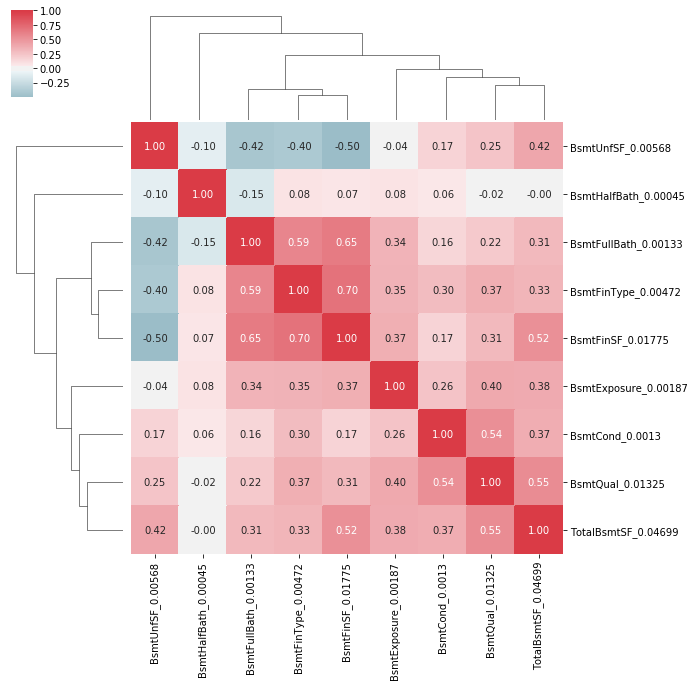

In [851]:
corr_mat_feat_2(df_train2.join(df_extra["SalePrice"]), ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType", "BsmtFinSF", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"], clf.best_estimator_, "SalePrice")

{'No_Basement': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
{'No_Basement': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4}


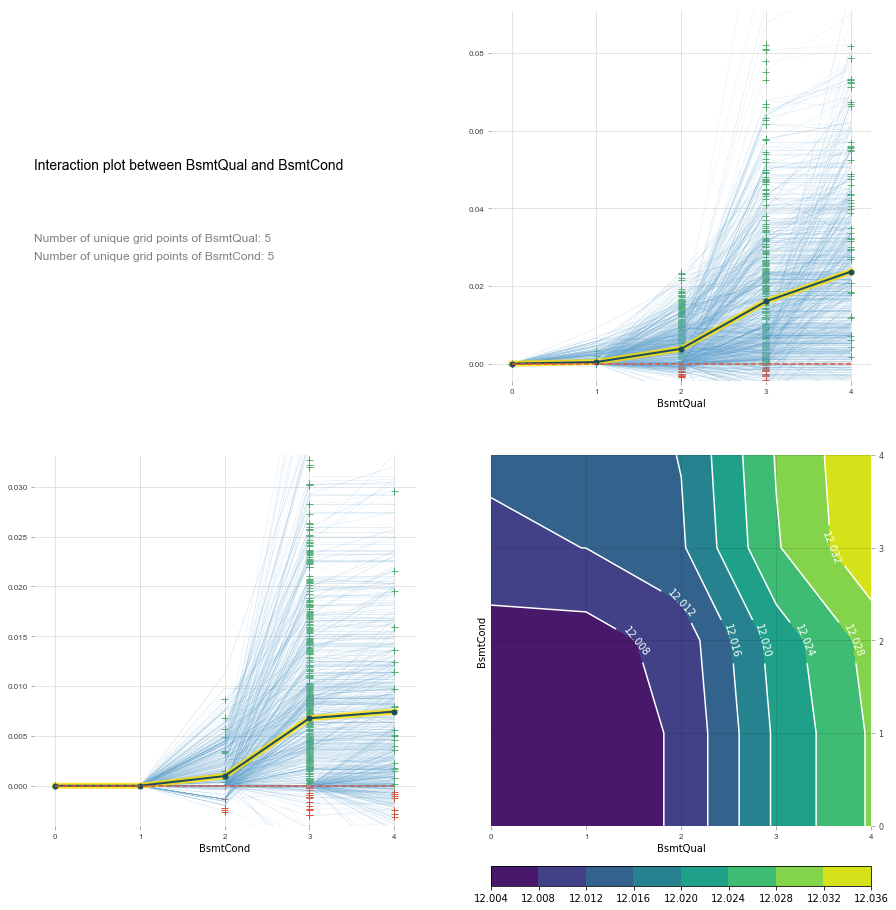

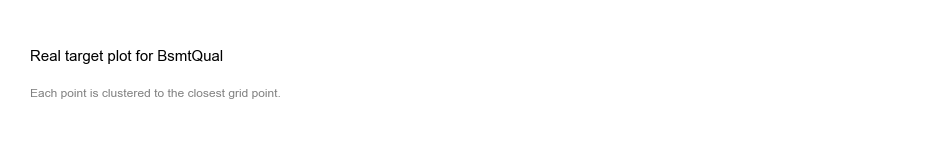

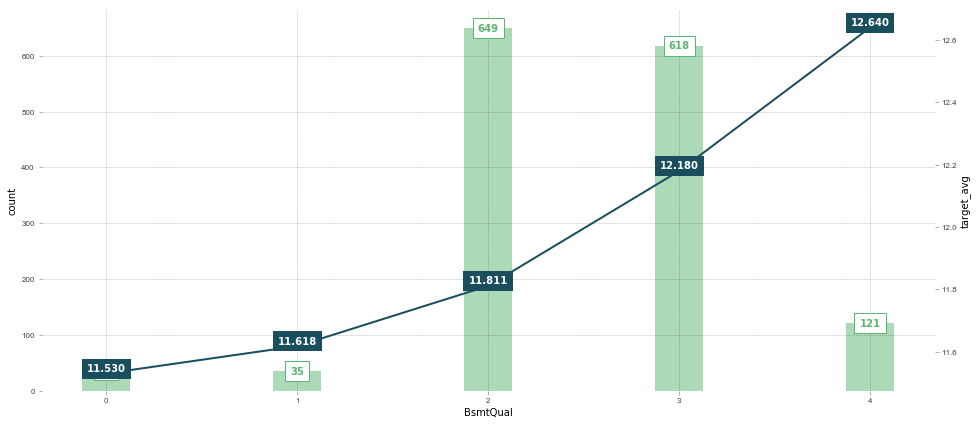

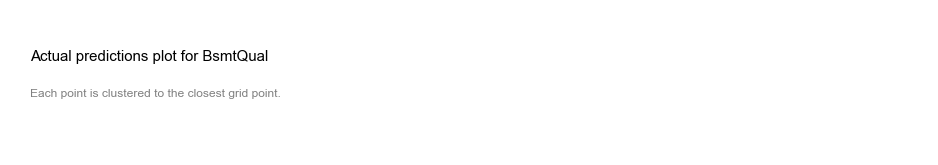

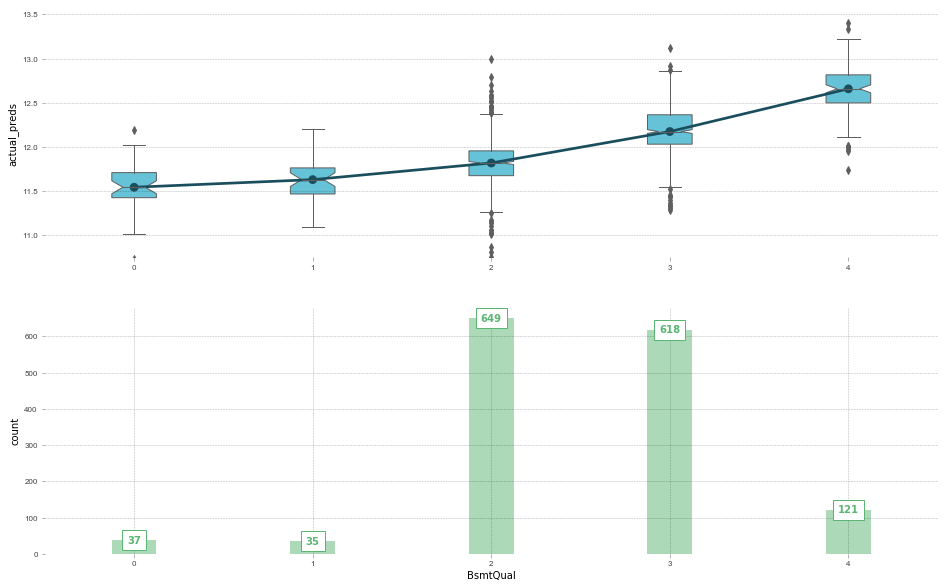

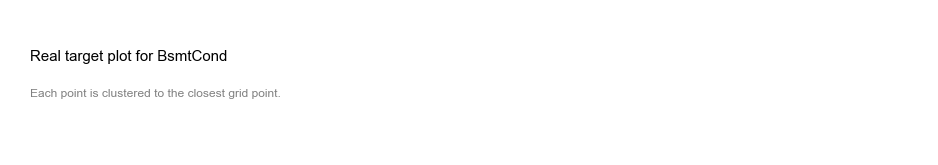

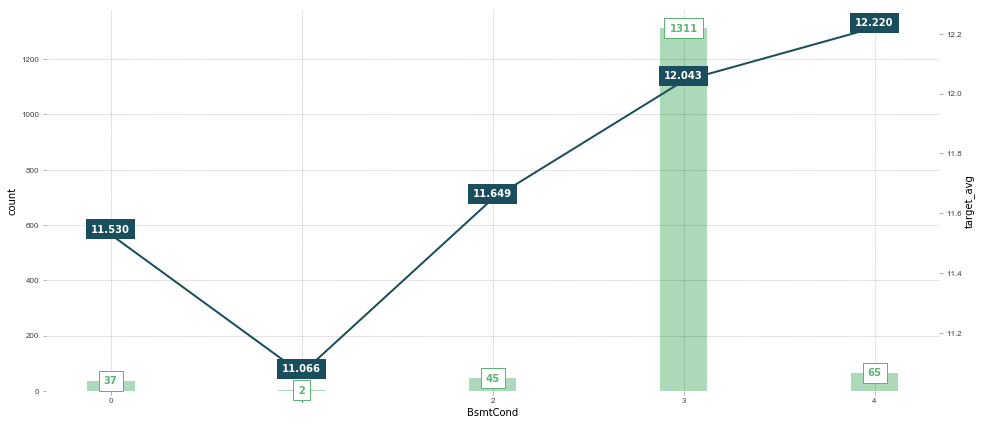

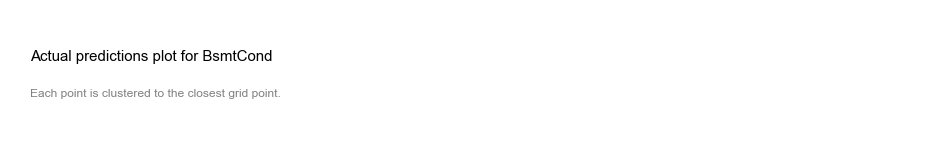

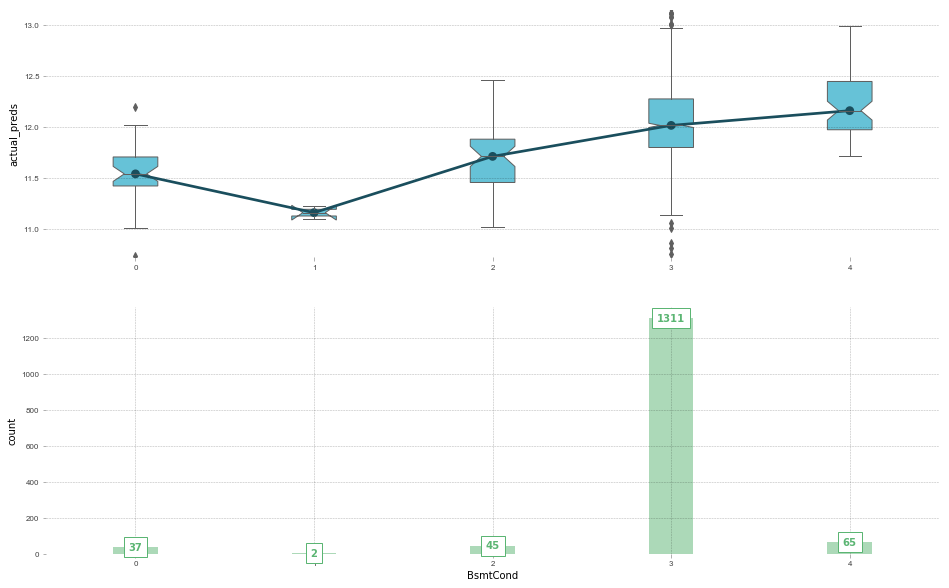

In [852]:
print(category_inv_mapper["BsmtQual"])
print(category_inv_mapper["BsmtCond"])
inter = pdp.pdp_interact(pipeline, df_train2, ['BsmtQual', 'BsmtCond'], num_grid_points=[10, 10])
pdp.pdp_interact_plot(inter, ['BsmtQual', 'BsmtCond'], center=True, plot_org_pts=True, plot_lines=True, frac_to_plot=0.5, x_quantile=True)
pdp.target_plot(df_train2.join(df_extra["SalePrice"]), 'BsmtQual', 'BsmtQual', 'SalePrice')

In [854]:
print("baseline: ", baseline_score)
for feat in ["BsmtCond", "BsmtQual"]:
    df_sub = df_train2.drop(feat, axis=1)
    random_forest = RandomForestRegressor()
    clf = GridSearchCV(random_forest, params, cv=n_folds, refit=True, scoring=make_scorer(rmse))
    clf.fit(df_train, y)
    print(feat+" RMSE: %0.5f (+/- %0.5f)" % (clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score']))

baseline:  [ 0.13667333]
BsmtCond RMSE: 0.13601 (+/- 0.00947)
BsmtQual RMSE: 0.13647 (+/- 0.01040)


In [855]:
dropped_cols = dropped_cols.join(df_train2["BsmtCond"])

In [856]:
df_train2.drop("BsmtCond", axis=1, inplace=True)

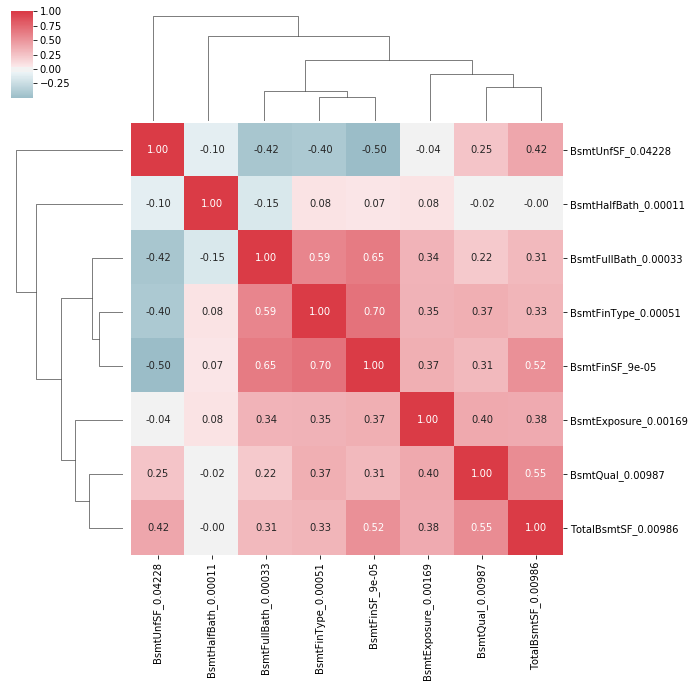

In [858]:
random_forest = RandomForestRegressor()
clf = GridSearchCV(random_forest, params, cv=n_folds, refit=True, scoring=make_scorer(rmse))
clf.fit(df_train2, y)
print("RMSE: %0.5f (+/- %0.5f)" % (clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score']))

RMSE: 0.13668 (+/- 0.01027)


In [859]:
df_test2 = df_test.copy()

In [860]:
df_test2["BsmtFinType"] = df_test["BsmtFinType1"]
df_test2["BsmtFinSF"] = df_test["BsmtFinSF1"]
df_test2.drop(["BsmtFinType2", "BsmtFinType1", "BsmtFinSF2", "BsmtFinSF1", "BsmtCond", "Fireplaces", "PoolQC", "GarageArea", "GarageCond"], axis=1, inplace=True)

In [864]:
pred = clf.predict(df_test2.drop("Id", axis=1))

In [866]:
pd.DataFrame({"Id":df_test2["Id"] , "SalePrice":np.exp(pred)}).to_csv("data/sub_2.csv", index=False)

In [868]:
df_train = df_train2.copy()